In [1]:
pip install torchinfo

In [2]:
pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 55.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 69.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 89.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [1]:
import zipfile

with zipfile.ZipFile('/content/European Traffic Sign Dataset.zip', 'r') as zip_file:
     zip_file.extractall('/content/dataset')

In [2]:
import torch
from torchvision import datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torchvision
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch import flatten
import torch.optim as optim
import os,random
import time
import torchvision.transforms as transforms
from torch.utils.data import WeightedRandomSampler

In [3]:
if torch.cuda.is_available():
   device_name = torch.cuda.get_device_name(0)
   print("Device used : ", device_name)
   device = "cuda"
else:
   print("Device unavailable")
   device = "cpu"

Device used :  Tesla T4


In [4]:
#Load the dataset
transform = transforms.Compose([transforms.Resize((40,40)),
                                transforms.ToTensor(),
                                transforms.Normalize(0.5,0.5)])

In [5]:
for root,directories,files in os.walk('/content/dataset/European Traffic Sign Dataset/Testing', topdown=False):
    for directory in directories:
        if not os.listdir(os.path.join(root,directory)):
           os.rmdir(os.path.join(root,directory))

In [6]:
from torch.utils.data import ConcatDataset

train_data = datasets.ImageFolder(root='/content/dataset/European Traffic Sign Dataset/Training',transform=transform)
test_data = datasets.ImageFolder(root='/content/dataset/European Traffic Sign Dataset/Testing',transform=transform)

dataset = ConcatDataset([train_data, test_data])
data_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

In [7]:
num_classes = len(list(set(train_data.classes + test_data.classes)))

print("Total number of classes:", num_classes)

Total number of classes: 54


In [8]:
#Splitting the dataset into training, testing and validation

from sklearn.model_selection import train_test_split

train_data, test_data1 = train_test_split(dataset, test_size=0.30, random_state=42,shuffle = True)
test_data, vald_data = train_test_split(test_data1, test_size=0.50, random_state=42,shuffle = True)

In [9]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(vald_data, batch_size=64, shuffle=True)

In [10]:
#Dataset Analysis

print("Total Number of images in Training Data:",len(train_data))
print("Total Number of images in Validation Data:",len(vald_data))
print("Total Number of images in Testing Data:",len(test_data))

Total Number of images in Training Data: 12255
Total Number of images in Validation Data: 2627
Total Number of images in Testing Data: 2626


##VGG-13 Version B

In [27]:
class VGG13(nn.Module):
    def __init__(self, num_classes=54):
        super(VGG13, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [28]:
from torchsummary import summary
model = VGG13(num_classes=54).to(device)

print(model)
summary(model, (3, 40, 40))

VGG13(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16)

In [29]:
def train_model(model,epochs_no,train_loader,test_loader,val_loader,optimizer,criterion):

    for epoch in range(epochs_no):

        train_pred=[]
        vald_pred=[]
        total_length=0

        total_training_loss=0.0
        model.train()
        for data in train_loader:
            inputs,target = data
            inputs,target = inputs.to(device),target.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            Prob = nn.Softmax(dim=1)(outputs)
            Y_pred = Prob.argmax(1).int()
            train_pred.append(accuracy(Y_pred,target).item())
            loss = criterion(outputs,target)
            loss.backward()
            optimizer.step()
            total_training_loss += loss.item()
            batch_length = target.size(0)
            total_length += batch_length
        total_training_loss/= total_length


        total_length =0

        model.to(device)
        model.eval()
        total_validation_loss = 0.0
        with torch.no_grad():
            for data in val_loader:
                inputs,target = data
                inputs,target = inputs.to(device),target.to(device)
                outputs = model(inputs)
                Prob = nn.Softmax(dim=1)(outputs)
                Y_pred = Prob.argmax(1).int()
                vald_pred.append(accuracy(Y_pred,target).item())
                val_loss = criterion(outputs, target)
                total_validation_loss += val_loss.item()
                batch_length = target.size(0)
                total_length += batch_length
        total_validation_loss/= total_length

        training_acc_data.append(sum(train_pred)/len(train_pred))
        val_acc_data.append(sum(vald_pred)/len(vald_pred))

        training_loss_data.append(total_training_loss)
        val_loss_data.append(total_validation_loss)

        print(f'Epoch: {epoch}, Loss: {total_training_loss}, val_loss:{total_validation_loss}')

    return training_loss_data, val_loss_data,training_acc_data,val_acc_data


In [30]:
import torch.optim as optim
from sklearn.metrics import precision_recall_fscore_support
from torchmetrics import Accuracy
import time

accuracy = Accuracy(task = "multiclass", num_classes=54).to(device)

training_loss_data =[]
val_loss_data =[]

training_acc_data =[]
val_acc_data =[]

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)
epoch_no = 10

training_loss_data,val_loss_data,training_acc_data,val_acc_data = train_model(model,epoch_no,train_loader,test_loader,val_loader,optimizer,criterion)

Epoch: 0, Loss: 0.0428253826731227, val_loss:0.04018227446882453
Epoch: 1, Loss: 0.03110642017320145, val_loss:0.019398633102795267
Epoch: 2, Loss: 0.01641933342623545, val_loss:0.015550419387592305
Epoch: 3, Loss: 0.01244593871972455, val_loss:0.010309007936300867
Epoch: 4, Loss: 0.010385186552563671, val_loss:0.009192661500312912
Epoch: 5, Loss: 0.008475295323247766, val_loss:0.008482617924864136
Epoch: 6, Loss: 0.007696297306374403, val_loss:0.007276809664792692
Epoch: 7, Loss: 0.006727327177204535, val_loss:0.008120147037016016
Epoch: 8, Loss: 0.006689150582790764, val_loss:0.007066494284313262
Epoch: 9, Loss: 0.0060251402798986884, val_loss:0.006937366181741344


In [34]:
start_time = time.time()

testing_loss_data = []
testing_acc_data = []


for epoch in range(epoch_no):

    total_testing_loss = 0.0
    testing_pred=[]
    predictions =[]
    Y_test =[]
    total_length = 0

    model.to(device)
    model.eval()
    with torch.no_grad():
        for data in test_loader:
            inputs,target = data
            inputs,target = inputs.to(device),target.to(device)
            outputs = model(inputs)
            Prob = nn.Softmax(dim=1)(outputs)
            Y_pred = Prob.argmax(1).int()
            predictions.append(Y_pred)
            Y_test.append(target)
            testing_pred.append(accuracy(Y_pred,target).item())
            test_loss = criterion(outputs, target)
            total_testing_loss += test_loss.item()
            batch_length = target.size(0)
            total_length += batch_length
        total_testing_loss/= total_length

    testing_acc_data.append(sum(testing_pred)/len(testing_pred))
    testing_loss_data.append(total_testing_loss)

Y_pred1 = predictions
Y_test1 = Y_test
Y_pred = torch.cat(predictions)
Y_test = torch.cat(Y_test)
Final_accuracy = accuracy(Y_pred,Y_test).item()
precision,recall,f1, support = precision_recall_fscore_support(Y_test.cpu(),Y_pred.cpu())
training_time = time.time() - start_time

print("Performance Metrics:")
print(f"Time to Train : {training_time} seconds")
print(f"Accuracy      : {Final_accuracy*100:.2f} %")
print(f"Precison      : {precision} ")
print(f"Recall        : {recall} ")
print(f"F1 Score      : {f1} ")
print()
print()

Performance Metrics:
Time to Train : 5.448246955871582 seconds
Accuracy      : 84.20 %
Precison      : [1.         0.71573604 0.         0.8        0.         0.82191781
 0.93736501 0.96067416 0.89473684 0.95409836 0.         1.
 0.71052632 0.27536232 0.82051282 0.85185185 0.         0.83798883
 0.94666667 0.92941176 0.87276342 0.         0.         0.
 0.35714286 0.         0.44444444 0.88888889 0.         0.
 0.         0.         0.         0.38888889 0.78571429 0.14285714
 0.         0.        ] 
Recall        : [0.96666667 0.96575342 0.         1.         0.         0.90909091
 0.90605428 0.97714286 0.77272727 1.         0.         0.6875
 0.75       0.42222222 0.34782609 0.42592593 0.         0.96153846
 0.97260274 0.89772727 0.99097065 0.         0.         0.
 0.7        0.         1.         0.72727273 0.         0.
 0.         0.         0.         0.5        0.84615385 0.07692308
 0.         0.        ] 
F1 Score      : [0.98305085 0.82215743 0.         0.88888889 0.        

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
print("Accuracy and Loss values:")
print()
print(f"Training Accuracy : {(sum(training_acc_data)/len(training_acc_data))*100:.2f} %")
print(f"Validation Accuracy : {(sum(val_acc_data)/len(val_acc_data))*100:.2f} %")
print(f"Testing Accuracy : {(sum(testing_acc_data)/len(testing_acc_data))*100:.2f} %")
print()
print(f"Training Loss : {(sum(training_loss_data)/len(training_loss_data))}")
print(f"Validation Loss : {(sum(val_loss_data)/len(val_loss_data))}")
print(f"Testing Loss : {(sum(testing_loss_data)/len(testing_loss_data))}")

Accuracy and Loss values:

Training Accuracy : 70.26 %
Validation Accuracy : 73.56 %
Testing Accuracy : 84.56 %

Training Loss : 0.014879547221436399
Validation Loss : 0.013251643148855333
Testing Loss : 0.008058035063861619


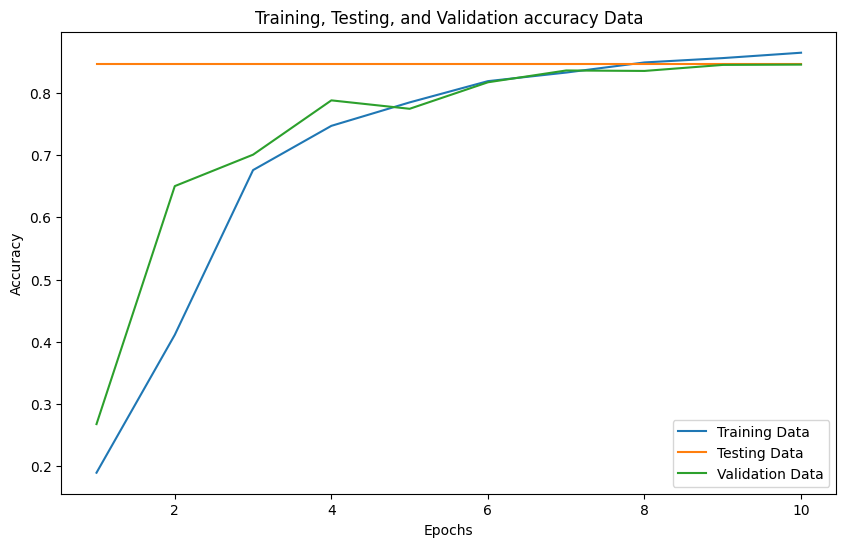

In [36]:
epochs = range(1,epoch_no+1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, training_acc_data, label='Training Data')
plt.plot(epochs, testing_acc_data, label='Testing Data')
plt.plot(epochs, val_acc_data, label='Validation Data')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training, Testing, and Validation accuracy Data')
plt.legend()
plt.show()

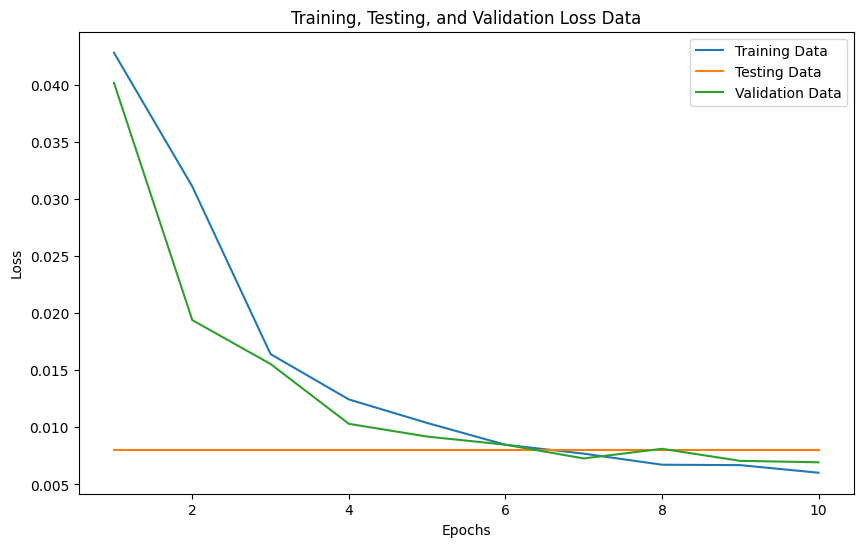

In [37]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss_data, label='Training Data')
plt.plot(epochs, testing_loss_data, label='Testing Data')
plt.plot(epochs, val_loss_data, label='Validation Data')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Testing, and Validation Loss Data')
plt.legend()
plt.show()

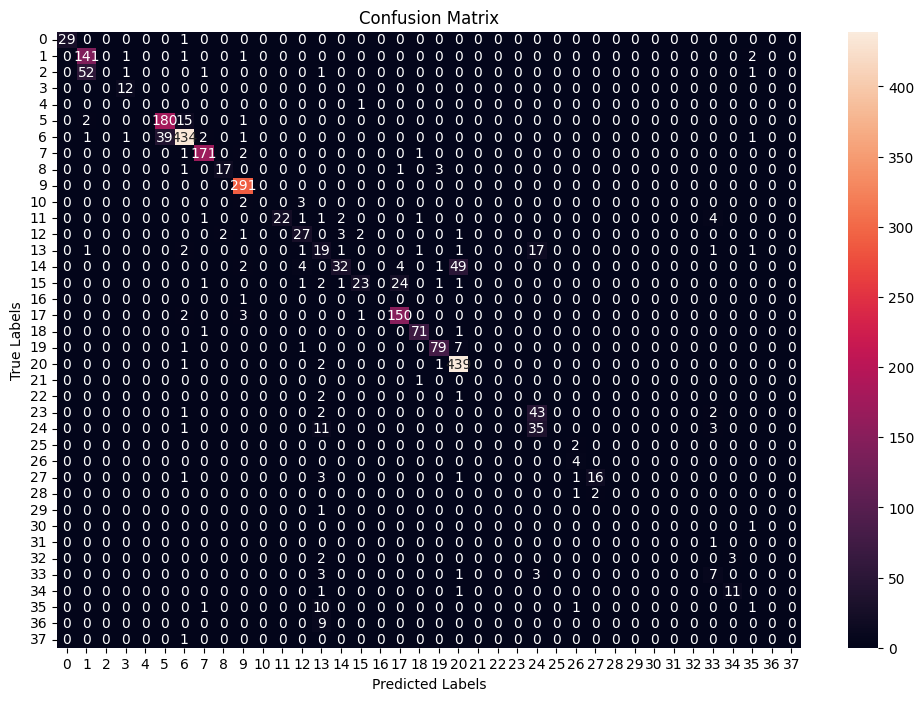

In [40]:
#Visualize the results
import seaborn as sns

from sklearn.metrics import confusion_matrix

cmat = confusion_matrix(Y_test.cpu(), Y_pred.cpu())
plt.figure(figsize=(12, 8))
sns.heatmap(cmat, annot=True, fmt="d")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


print()
print()


##VGG Hyperparameter Tuning

##Model 1 - Regularization

In [20]:
class VGG13(nn.Module):
    def __init__(self, num_classes=54):
        super(VGG13, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [21]:
from torchsummary import summary
model1 = VGG13(num_classes=54).to(device)

print(model1)
summary(model1, (3, 40, 40))

VGG13(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16)

In [22]:
def train_model(model1,epochs_no,train_loader,test_loader,val_loader,optimizer,criterion):

    for epoch in range(epochs_no):

        train_pred=[]
        vald_pred=[]
        total_length=0

        total_training_loss=0.0
        model1.train()
        for data in train_loader:
            inputs,target = data
            inputs,target = inputs.to(device),target.to(device)
            optimizer.zero_grad()
            outputs = model1(inputs)
            Prob = nn.Softmax(dim=1)(outputs)
            Y_pred = Prob.argmax(1).int()
            train_pred.append(accuracy(Y_pred,target).item())
            loss = criterion(outputs,target)
            loss.backward()
            optimizer.step()
            total_training_loss += loss.item()
            batch_length = target.size(0)
            total_length += batch_length
        total_training_loss/= total_length


        total_length =0

        model1.to(device)
        model1.eval()
        total_validation_loss = 0.0
        with torch.no_grad():
            for data in val_loader:
                inputs,target = data
                inputs,target = inputs.to(device),target.to(device)
                outputs = model1(inputs)
                Prob = nn.Softmax(dim=1)(outputs)
                Y_pred = Prob.argmax(1).int()
                vald_pred.append(accuracy(Y_pred,target).item())
                val_loss = criterion(outputs, target)
                total_validation_loss += val_loss.item()
                batch_length = target.size(0)
                total_length += batch_length
        total_validation_loss/= total_length

        training_acc_data.append(sum(train_pred)/len(train_pred))
        val_acc_data.append(sum(vald_pred)/len(vald_pred))

        training_loss_data.append(total_training_loss)
        val_loss_data.append(total_validation_loss)

        print(f'Epoch: {epoch}, Loss: {loss}, val_loss:{total_validation_loss}')

    return training_loss_data, val_loss_data,training_acc_data,val_acc_data


In [23]:
import torch.optim as optim
from sklearn.metrics import precision_recall_fscore_support
from torchmetrics import Accuracy
import time

accuracy = Accuracy(task = "multiclass", num_classes=54).to(device)

training_loss_data =[]
val_loss_data =[]

training_acc_data =[]
val_acc_data =[]

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model1.parameters(),lr=0.001, weight_decay= 1e-5)
epoch_no = 50

training_loss_data,val_loss_data,training_acc_data,val_acc_data = train_model(model1,epoch_no,train_loader,test_loader,val_loader,optimizer,criterion)

Epoch: 0, Loss: 2.3312227725982666, val_loss:0.035214310732457774
Epoch: 1, Loss: 1.0256245136260986, val_loss:0.016500858058936703
Epoch: 2, Loss: 0.33625486493110657, val_loss:0.011857840081880336
Epoch: 3, Loss: 0.2100246250629425, val_loss:0.009769367840428927
Epoch: 4, Loss: 0.3743997812271118, val_loss:0.00815205356559238
Epoch: 5, Loss: 0.5266731977462769, val_loss:0.0075826222537178295
Epoch: 6, Loss: 0.25341641902923584, val_loss:0.0076611746637186805
Epoch: 7, Loss: 0.4948968291282654, val_loss:0.007099357510547834
Epoch: 8, Loss: 0.48118677735328674, val_loss:0.006220937981991701
Epoch: 9, Loss: 0.32012516260147095, val_loss:0.006578809137484126
Epoch: 10, Loss: 0.30697131156921387, val_loss:0.00630656149639664
Epoch: 11, Loss: 0.19110724329948425, val_loss:0.006181542685402179
Epoch: 12, Loss: 0.21623481810092926, val_loss:0.005119140357414397
Epoch: 13, Loss: 0.15184040367603302, val_loss:0.005715228013090185
Epoch: 14, Loss: 0.7505896091461182, val_loss:0.0066898527722146

In [24]:
start_time = time.time()

testing_loss_data = []
testing_acc_data = []


for epoch in range(epoch_no):

    total_testing_loss = 0.0
    testing_pred=[]
    predictions =[]
    Y_test =[]
    total_length = 0

    model1.to(device)
    model1.eval()
    with torch.no_grad():
        for data in test_loader:
            inputs,target = data
            inputs,target = inputs.to(device),target.to(device)
            outputs = model1(inputs)
            Prob = nn.Softmax(dim=1)(outputs)
            Y_pred = Prob.argmax(1).int()
            predictions.append(Y_pred)
            Y_test.append(target)
            testing_pred.append(accuracy(Y_pred,target).item())
            test_loss = criterion(outputs, target)
            total_testing_loss += test_loss.item()
            batch_length = target.size(0)
            total_length += batch_length
        total_testing_loss/= total_length

    testing_acc_data.append(sum(testing_pred)/len(testing_pred))
    testing_loss_data.append(total_testing_loss)

Y_pred1 = predictions
Y_test1 = Y_test
Y_pred = torch.cat(predictions)
Y_test = torch.cat(Y_test)
Final_accuracy = accuracy(Y_pred,Y_test).item()
precision,recall,f1, support = precision_recall_fscore_support(Y_test.cpu(),Y_pred.cpu())
training_time = time.time() - start_time

print("Performance Metrics:")
print(f"Time to Train : {training_time} seconds")
print(f"Accuracy      : {Final_accuracy*100:.2f} %")
print(f"Precison      : {precision} ")
print(f"Recall        : {recall} ")
print(f"F1 Score      : {f1} ")
print()
print()

Performance Metrics:
Time to Train : 27.098004579544067 seconds
Accuracy      : 91.13 %
Precison      : [0.96774194 0.83870968 0.69811321 0.92307692 1.         0.87142857
 0.97149123 0.96571429 0.94736842 0.98630137 0.         0.78378378
 0.79545455 0.50746269 0.81967213 0.89130435 1.         0.93902439
 1.         1.         0.         0.91176471 0.         0.
 0.         0.89795918 1.         0.         1.         0.8
 0.95238095 1.         0.         0.         0.         0.75
 0.78571429 0.92307692 0.69230769 0.         0.        ] 
Recall        : [1.         0.89041096 0.66071429 1.         1.         0.92424242
 0.92484342 0.96571429 0.81818182 0.98969072 0.         0.90625
 0.97222222 0.75555556 0.54347826 0.75925926 1.         0.98717949
 0.94520548 0.90909091 0.         0.97968397 0.         0.
 0.         0.91666667 0.98       0.         1.         1.
 0.90909091 0.33333333 0.         0.         0.         0.6
 0.78571429 0.92307692 0.69230769 0.         0.        ] 
F1 Scor

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
print("Accuracy and Loss values:")
print()
print(f"Training Accuracy : {(sum(training_acc_data)/len(training_acc_data))*100:.2f} %")
print(f"Validation Accuracy : {(sum(val_acc_data)/len(val_acc_data))*100:.2f} %")
print(f"Testing Accuracy : {(sum(testing_acc_data)/len(testing_acc_data))*100:.2f} %")
print()
print(f"Training Loss : {(sum(training_loss_data)/len(training_loss_data))}")
print(f"Validation Loss : {(sum(val_loss_data)/len(val_loss_data))}")
print(f"Testing Loss : {(sum(testing_loss_data)/len(testing_loss_data))}")

Accuracy and Loss values:

Training Accuracy : 18.81 %
Validation Accuracy : 19.52 %
Testing Accuracy : 18.97 %

Training Loss : 0.042534261055257254
Validation Loss : 0.043470158057835426
Testing Loss : 0.04345232743120158


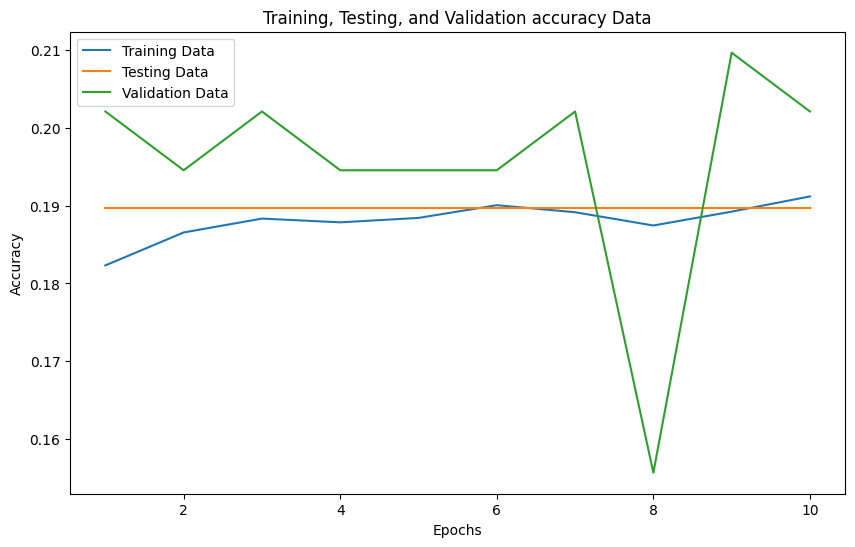

In [17]:
epochs = range(1,epoch_no+1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, training_acc_data, label='Training Data')
plt.plot(epochs, testing_acc_data, label='Testing Data')
plt.plot(epochs, val_acc_data, label='Validation Data')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training, Testing, and Validation accuracy Data')
plt.legend()
plt.show()

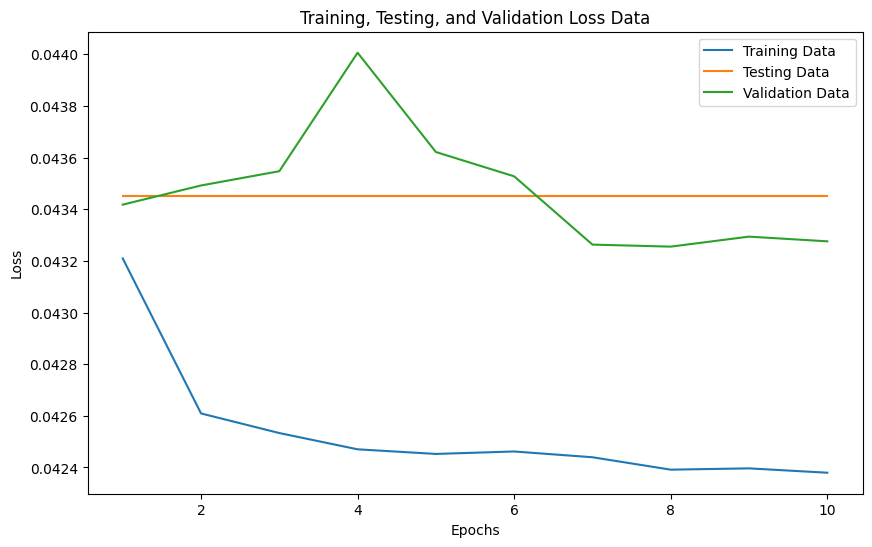

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss_data, label='Training Data')
plt.plot(epochs, testing_loss_data, label='Testing Data')
plt.plot(epochs, val_loss_data, label='Validation Data')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Testing, and Validation Loss Data')
plt.legend()
plt.show()

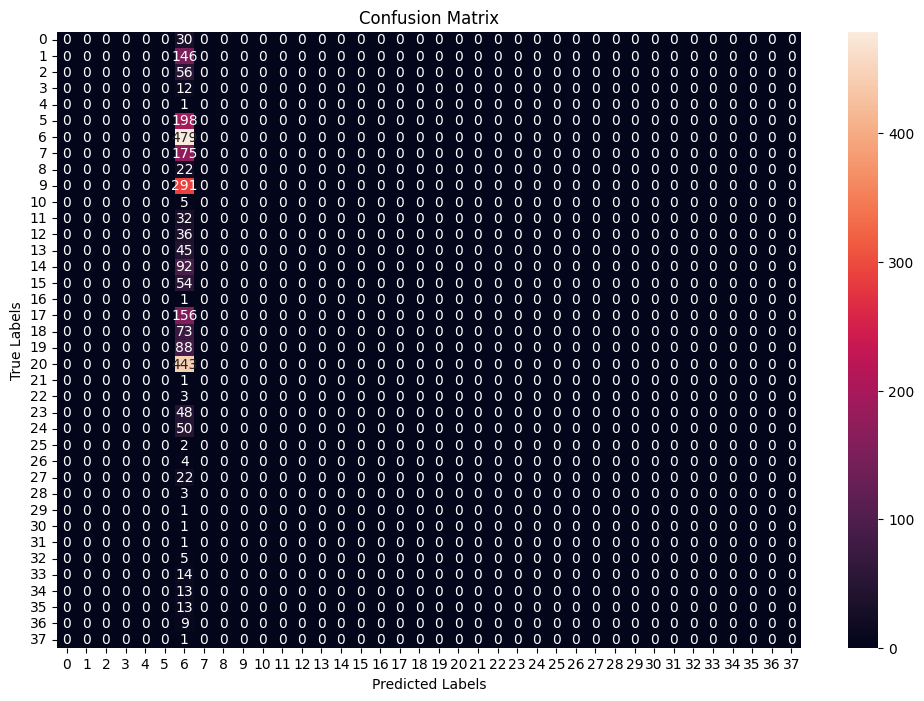

In [19]:
#Visualize the results
import seaborn as sns

from sklearn.metrics import confusion_matrix

cmat = confusion_matrix(Y_test.cpu(), Y_pred.cpu())
plt.figure(figsize=(12, 8))
sns.heatmap(cmat, annot=True, fmt="d")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


print()
print()


##Model - 2
Drop Out

In [31]:
class VGG13(nn.Module):
    def __init__(self, num_classes=54, dropout_prob = 0.5):
        super(VGG13, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p = dropout_prob),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p = dropout_prob),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [32]:
from torchsummary import summary
model2 = VGG13(num_classes=54, dropout_prob = 0.5).to(device)

print(model2)
summary(model2, (3, 40, 40))

VGG13(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16)

In [33]:
def train_model(model2,epochs_no,train_loader,test_loader,val_loader,optimizer,criterion):

    for epoch in range(epochs_no):

        train_pred=[]
        vald_pred=[]
        total_length=0

        total_training_loss=0.0
        model2.train()
        for data in train_loader:
            inputs,target = data
            inputs,target = inputs.to(device),target.to(device)
            optimizer.zero_grad()
            outputs = model2(inputs)
            Prob = nn.Softmax(dim=1)(outputs)
            Y_pred = Prob.argmax(1).int()
            train_pred.append(accuracy(Y_pred,target).item())
            loss = criterion(outputs,target)
            loss.backward()
            optimizer.step()
            total_training_loss += loss.item()
            batch_length = target.size(0)
            total_length += batch_length
        total_training_loss/= total_length


        total_length =0

        model2.to(device)
        model2.eval()
        total_validation_loss = 0.0
        with torch.no_grad():
            for data in val_loader:
                inputs,target = data
                inputs,target = inputs.to(device),target.to(device)
                outputs = model2(inputs)
                Prob = nn.Softmax(dim=1)(outputs)
                Y_pred = Prob.argmax(1).int()
                vald_pred.append(accuracy(Y_pred,target).item())
                val_loss = criterion(outputs, target)
                total_validation_loss += val_loss.item()
                batch_length = target.size(0)
                total_length += batch_length
        total_validation_loss/= total_length

        training_acc_data.append(sum(train_pred)/len(train_pred))
        val_acc_data.append(sum(vald_pred)/len(vald_pred))

        training_loss_data.append(total_training_loss)
        val_loss_data.append(total_validation_loss)

        print(f'Epoch: {epoch}, Loss: {loss}, val_loss:{total_validation_loss}')

    return training_loss_data, val_loss_data,training_acc_data,val_acc_data


In [34]:
import torch.optim as optim
from sklearn.metrics import precision_recall_fscore_support
from torchmetrics import Accuracy
import time

accuracy = Accuracy(task = "multiclass", num_classes=54).to(device)

training_loss_data =[]
val_loss_data =[]

training_acc_data =[]
val_acc_data =[]

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.parameters(),lr=0.001 , weight_decay= 1e-5)
epoch_no = 30


training_loss_data,val_loss_data,training_acc_data,val_acc_data = train_model(model2,epoch_no,train_loader,test_loader,val_loader,optimizer,criterion)

Epoch: 0, Loss: 1.9577454328536987, val_loss:0.03804849543678565
Epoch: 1, Loss: 1.2282555103302002, val_loss:0.022296215401523503
Epoch: 2, Loss: 1.1848381757736206, val_loss:0.013789032342364047
Epoch: 3, Loss: 0.5532023906707764, val_loss:0.011206670523506632
Epoch: 4, Loss: 0.6147885918617249, val_loss:0.009218746779942449
Epoch: 5, Loss: 0.871441662311554, val_loss:0.008223539750794744
Epoch: 6, Loss: 0.35807880759239197, val_loss:0.006981637265049644
Epoch: 7, Loss: 0.4770641028881073, val_loss:0.006610195872490516
Epoch: 8, Loss: 0.43689537048339844, val_loss:0.006738925824203462
Epoch: 9, Loss: 0.7138184309005737, val_loss:0.005953915051330302
Epoch: 10, Loss: 0.2696083188056946, val_loss:0.00667892672124361
Epoch: 11, Loss: 0.1630321741104126, val_loss:0.005507010274517432
Epoch: 12, Loss: 0.13806211948394775, val_loss:0.005225006968660764
Epoch: 13, Loss: 0.2714025378227234, val_loss:0.005259236286110328
Epoch: 14, Loss: 0.301429808139801, val_loss:0.004883530781915263
Epoch:

In [35]:
start_time = time.time()

testing_loss_data = []
testing_acc_data = []


for epoch in range(epoch_no):

    total_testing_loss = 0.0
    testing_pred=[]
    predictions =[]
    Y_test =[]
    total_length = 0

    model2.to(device)
    model2.eval()
    with torch.no_grad():
        for data in test_loader:
            inputs,target = data
            inputs,target = inputs.to(device),target.to(device)
            outputs = model2(inputs)
            Prob = nn.Softmax(dim=1)(outputs)
            Y_pred = Prob.argmax(1).int()
            predictions.append(Y_pred)
            Y_test.append(target)
            testing_pred.append(accuracy(Y_pred,target).item())
            test_loss = criterion(outputs, target)
            total_testing_loss += test_loss.item()
            batch_length = target.size(0)
            total_length += batch_length
        total_testing_loss/= total_length

    testing_acc_data.append(sum(testing_pred)/len(testing_pred))
    testing_loss_data.append(total_testing_loss)

Y_pred1 = predictions
Y_test1 = Y_test
Y_pred = torch.cat(predictions)
Y_test = torch.cat(Y_test)
Final_accuracy = accuracy(Y_pred,Y_test).item()
precision,recall,f1, support = precision_recall_fscore_support(Y_test.cpu(),Y_pred.cpu())
training_time = time.time() - start_time

print("Performance Metrics:")
print(f"Time to Train : {training_time} seconds")
print(f"Accuracy      : {Final_accuracy*100:.2f} %")
print(f"Precison      : {precision} ")
print(f"Recall        : {recall} ")
print(f"F1 Score      : {f1} ")
print()
print()

Performance Metrics:
Time to Train : 16.326240301132202 seconds
Accuracy      : 91.47 %
Precison      : [1.         0.79310345 0.77777778 0.92307692 0.         0.82819383
 0.97333333 0.99411765 1.         0.97979798 0.         0.82352941
 0.92105263 0.53968254 0.94339623 0.95918367 0.         0.94512195
 0.98591549 1.         0.90946502 0.         1.         0.93181818
 0.98039216 0.5        1.         0.83333333 0.         1.
 0.5        0.         1.         0.55555556 1.         0.8
 0.33333333 0.        ] 
Recall        : [1.         0.94520548 0.375      1.         0.         0.94949495
 0.91440501 0.96571429 0.86363636 1.         0.         0.875
 0.97222222 0.75555556 0.54347826 0.87037037 0.         0.99358974
 0.95890411 0.94318182 0.99774266 0.         0.33333333 0.85416667
 1.         0.5        0.5        0.90909091 0.         1.
 1.         0.         0.8        0.71428571 0.84615385 0.61538462
 0.22222222 0.        ] 
F1 Score      : [1.         0.8625     0.5060241  0.96

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
print("Accuracy and Loss values:")
print()
print(f"Training Accuracy : {(sum(training_acc_data)/len(training_acc_data))*100:.2f} %")
print(f"Validation Accuracy : {(sum(val_acc_data)/len(val_acc_data))*100:.2f} %")
print(f"Testing Accuracy : {(sum(testing_acc_data)/len(testing_acc_data))*100:.2f} %")
print()
print(f"Training Loss : {(sum(training_loss_data)/len(training_loss_data))}")
print(f"Validation Loss : {(sum(val_loss_data)/len(val_loss_data))}")
print(f"Testing Loss : {(sum(testing_loss_data)/len(testing_loss_data))}")

Accuracy and Loss values:

Training Accuracy : 86.24 %
Validation Accuracy : 85.22 %
Testing Accuracy : 91.67 %

Training Loss : 0.006886523927708988
Validation Loss : 0.0078024242429841125
Testing Loss : 0.006990698191017387


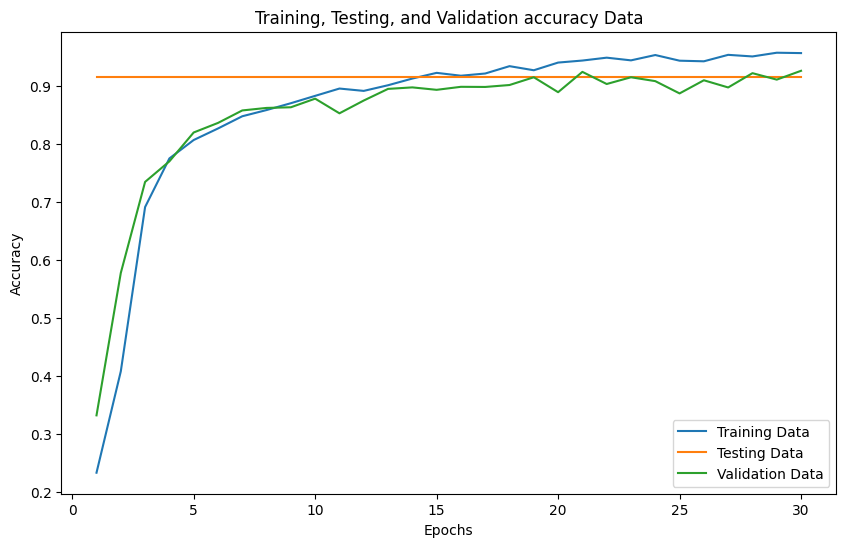

In [37]:
epochs = range(1,epoch_no+1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, training_acc_data, label='Training Data')
plt.plot(epochs, testing_acc_data, label='Testing Data')
plt.plot(epochs, val_acc_data, label='Validation Data')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training, Testing, and Validation accuracy Data')
plt.legend()
plt.show()

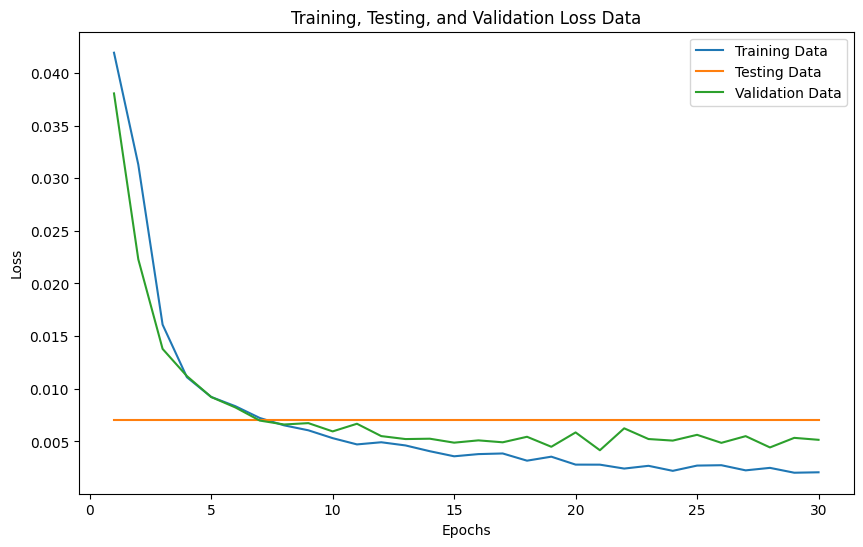

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss_data, label='Training Data')
plt.plot(epochs, testing_loss_data, label='Testing Data')
plt.plot(epochs, val_loss_data, label='Validation Data')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Testing, and Validation Loss Data')
plt.legend()
plt.show()

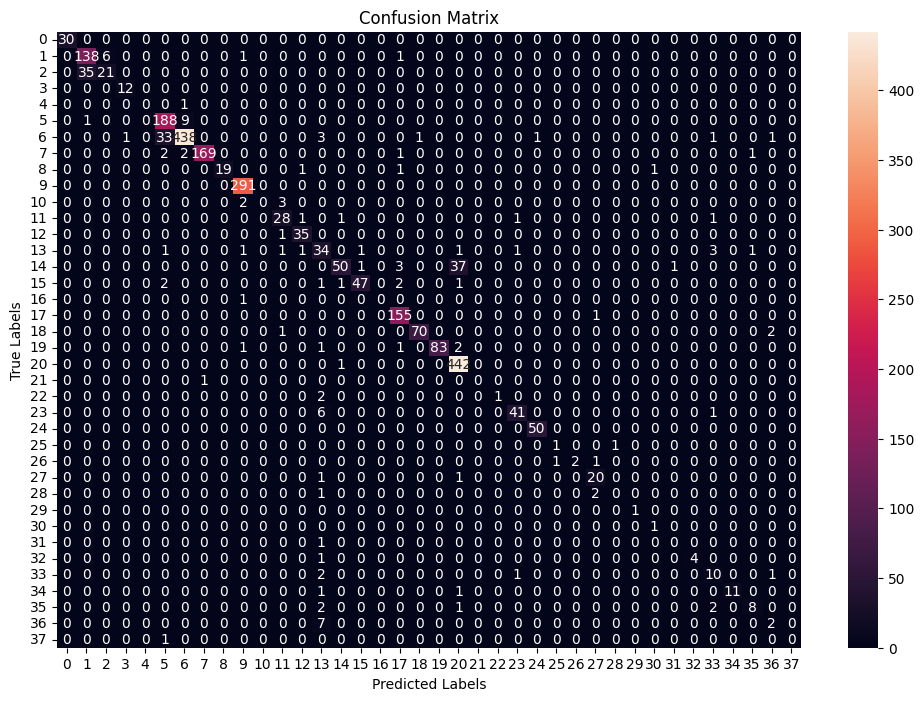

In [39]:
#Visualize the results
import seaborn as sns

from sklearn.metrics import confusion_matrix

cmat = confusion_matrix(Y_test.cpu(), Y_pred.cpu())
plt.figure(figsize=(12, 8))
sns.heatmap(cmat, annot=True, fmt="d")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


print()
print()


##Model - 3

Early Stopping

In [40]:
pip install pytorch-ignite

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 7.5 MB/s eta 0:00:00


In [41]:
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.handlers import EarlyStopping

In [42]:
class VGG13(nn.Module):
    def __init__(self, num_classes=54, dropout_prob = 0.5):
        super(VGG13, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p = dropout_prob),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p = dropout_prob),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [43]:
from torchsummary import summary
model3 = VGG13(num_classes=54, dropout_prob = 0.5).to(device)

print(model3)
summary(model3, (3, 40, 40))

VGG13(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16)

In [44]:
def train_model(model3,epochs_no,train_loader,test_loader,val_loader,optimizer,criterion):

    early_stopping_patience = 5
    best_validation_loss = float('inf')
    consecutive_increases = 0

    for epoch in range(epochs_no):

        train_pred=[]
        vald_pred=[]
        total_length=0

        total_training_loss=0.0
        model3.train()
        for data in train_loader:
            inputs,target = data
            inputs,target = inputs.to(device),target.to(device)
            optimizer.zero_grad()
            outputs = model3(inputs)
            Prob = nn.Softmax(dim=1)(outputs)
            Y_pred = Prob.argmax(1).int()
            train_pred.append(accuracy(Y_pred,target).item())
            loss = criterion(outputs,target)
            loss.backward()
            optimizer.step()
            total_training_loss += loss.item()
            batch_length = target.size(0)
            total_length += batch_length
        total_training_loss/= total_length


        total_length =0

        model3.to(device)
        model3.eval()
        total_validation_loss = 0.0
        with torch.no_grad():
            for data in val_loader:
                inputs,target = data
                inputs,target = inputs.to(device),target.to(device)
                outputs = model3(inputs)
                Prob = nn.Softmax(dim=1)(outputs)
                Y_pred = Prob.argmax(1).int()
                vald_pred.append(accuracy(Y_pred,target).item())
                val_loss = criterion(outputs, target)
                total_validation_loss += val_loss.item()
                batch_length = target.size(0)
                total_length += batch_length
        total_validation_loss/= total_length

        training_acc_data.append(sum(train_pred)/len(train_pred))
        val_acc_data.append(sum(vald_pred)/len(vald_pred))

        training_loss_data.append(total_training_loss)
        val_loss_data.append(total_validation_loss)

        print(f'Epoch: {epoch}, Loss: {loss}, val_loss:{total_validation_loss}')

        if total_validation_loss < best_validation_loss:
           best_validation_loss = total_validation_loss
           consecutive_increases = 0
        else:
           consecutive_increases += 1

        if consecutive_increases >= early_stopping_patience:
           print("Early stopping!")
           break

    return training_loss_data, val_loss_data,training_acc_data,val_acc_data,epoch


In [45]:
import torch.optim as optim
from sklearn.metrics import precision_recall_fscore_support
from torchmetrics import Accuracy
import time

accuracy = Accuracy(task = "multiclass", num_classes=54).to(device)

training_loss_data =[]
val_loss_data =[]

training_acc_data =[]
val_acc_data =[]

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model3.parameters(),lr=0.001, weight_decay= 1e-5)
epoch_no = 100

training_loss_data,val_loss_data,training_acc_data,val_acc_data,epoch = train_model(model3,epoch_no,train_loader,test_loader,val_loader,optimizer,criterion)

Epoch: 0, Loss: 1.9463551044464111, val_loss:0.03861277140634433
Epoch: 1, Loss: 1.122721552848816, val_loss:0.02288257081925211
Epoch: 2, Loss: 0.9567846059799194, val_loss:0.015673659149122002
Epoch: 3, Loss: 0.5766277313232422, val_loss:0.010970638557945226
Epoch: 4, Loss: 0.17619559168815613, val_loss:0.00969369647096308
Epoch: 5, Loss: 0.5546205639839172, val_loss:0.008090543530904094
Epoch: 6, Loss: 0.4215317368507385, val_loss:0.007352305443614982
Epoch: 7, Loss: 0.09073304384946823, val_loss:0.007094804749182072
Epoch: 8, Loss: 0.4143841862678528, val_loss:0.007925404090367663
Epoch: 9, Loss: 0.2886033356189728, val_loss:0.006357485332732242
Epoch: 10, Loss: 0.18525880575180054, val_loss:0.007321920159383105
Epoch: 11, Loss: 0.27976807951927185, val_loss:0.005408167006870604
Epoch: 12, Loss: 0.24555917084217072, val_loss:0.0058698781121126545
Epoch: 13, Loss: 0.3528766632080078, val_loss:0.009325756553488173
Epoch: 14, Loss: 0.3783784806728363, val_loss:0.006024956493310525
Epo

In [46]:
start_time = time.time()

testing_loss_data = []
testing_acc_data = []

epoch_no = epoch+1
for epoch in range(epoch_no):

    total_testing_loss = 0.0
    testing_pred=[]
    predictions =[]
    Y_test =[]
    total_length = 0

    model3.to(device)
    model3.eval()
    with torch.no_grad():
        for data in test_loader:
            inputs,target = data
            inputs,target = inputs.to(device),target.to(device)
            outputs = model3(inputs)
            Prob = nn.Softmax(dim=1)(outputs)
            Y_pred = Prob.argmax(1).int()
            predictions.append(Y_pred)
            Y_test.append(target)
            testing_pred.append(accuracy(Y_pred,target).item())
            test_loss = criterion(outputs, target)
            total_testing_loss += test_loss.item()
            batch_length = target.size(0)
            total_length += batch_length
        total_testing_loss/= total_length

    testing_acc_data.append(sum(testing_pred)/len(testing_pred))
    testing_loss_data.append(total_testing_loss)

Y_pred1 = predictions
Y_test1 = Y_test
Y_pred = torch.cat(predictions)
Y_test = torch.cat(Y_test)
Final_accuracy = accuracy(Y_pred,Y_test).item()
precision,recall,f1, support = precision_recall_fscore_support(Y_test.cpu(),Y_pred.cpu())
training_time = time.time() - start_time

print("Performance Metrics:")
print(f"Time to Train : {training_time} seconds")
print(f"Accuracy      : {Final_accuracy*100:.2f} %")
print(f"Precison      : {precision} ")
print(f"Recall        : {recall} ")
print(f"F1 Score      : {f1} ")
print()
print()

Performance Metrics:
Time to Train : 14.736067771911621 seconds
Accuracy      : 91.20 %
Precison      : [0.96774194 0.82634731 0.8        1.         0.5        0.85185185
 0.97587719 0.98843931 1.         0.98639456 1.         0.93333333
 0.89473684 0.53488372 0.75384615 0.95555556 0.16666667 0.96273292
 1.         0.96511628 0.91422594 0.         0.33333333 0.85714286
 1.         0.         0.         0.33333333 0.85       0.
 0.         1.         0.5        0.75       0.61111111 0.66666667
 0.         0.77777778 0.5        0.        ] 
Recall        : [1.         0.94520548 0.5        0.91666667 1.         0.92929293
 0.92901879 0.97714286 0.95454545 0.99656357 0.2        0.875
 0.94444444 0.51111111 0.5326087  0.7962963  1.         0.99358974
 0.95890411 0.94318182 0.98645598 0.         0.33333333 0.875
 1.         0.         0.         1.         0.77272727 0.
 0.         1.         1.         0.6        0.78571429 0.92307692
 0.         0.53846154 0.33333333 0.        ] 
F1 Score

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [47]:
print("Accuracy and Loss values:")
print()
print(f"Training Accuracy : {(sum(training_acc_data)/len(training_acc_data))*100:.2f} %")
print(f"Validation Accuracy : {(sum(val_acc_data)/len(val_acc_data))*100:.2f} %")
print(f"Testing Accuracy : {(sum(testing_acc_data)/len(testing_acc_data))*100:.2f} %")
print()
print(f"Training Loss : {(sum(training_loss_data)/len(training_loss_data))}")
print(f"Validation Loss : {(sum(val_loss_data)/len(val_loss_data))}")
print(f"Testing Loss : {(sum(testing_loss_data)/len(testing_loss_data))}")

Accuracy and Loss values:

Training Accuracy : 84.71 %
Validation Accuracy : 83.77 %
Testing Accuracy : 91.41 %

Training Loss : 0.007639110544703066
Validation Loss : 0.0086301078904548
Testing Loss : 0.005785576993512998


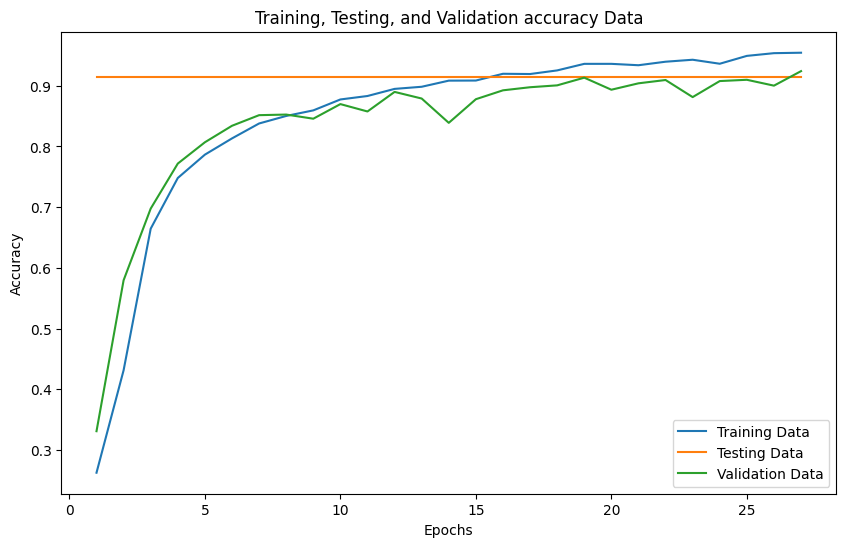

In [48]:
epochs = range(1,epoch_no+1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, training_acc_data, label='Training Data')
plt.plot(epochs, testing_acc_data, label='Testing Data')
plt.plot(epochs, val_acc_data, label='Validation Data')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training, Testing, and Validation accuracy Data')
plt.legend()
plt.show()

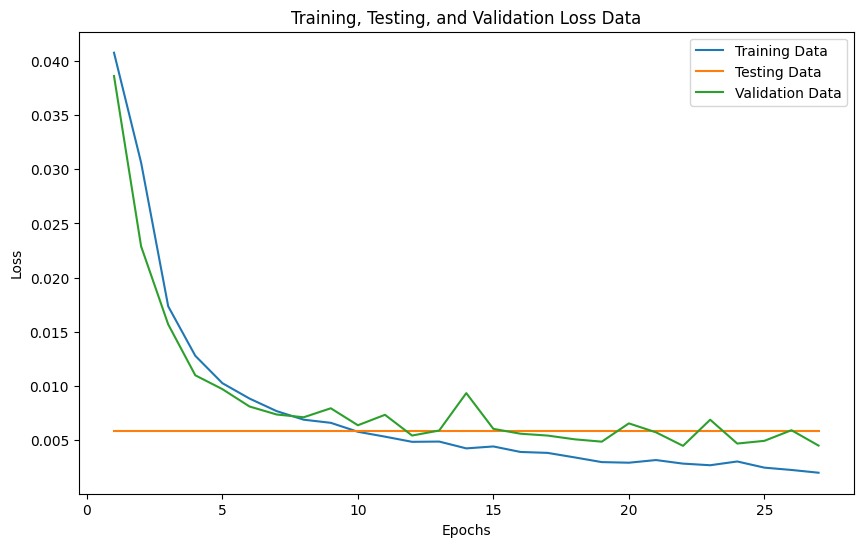

In [49]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss_data, label='Training Data')
plt.plot(epochs, testing_loss_data, label='Testing Data')
plt.plot(epochs, val_loss_data, label='Validation Data')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Testing, and Validation Loss Data')
plt.legend()
plt.show()

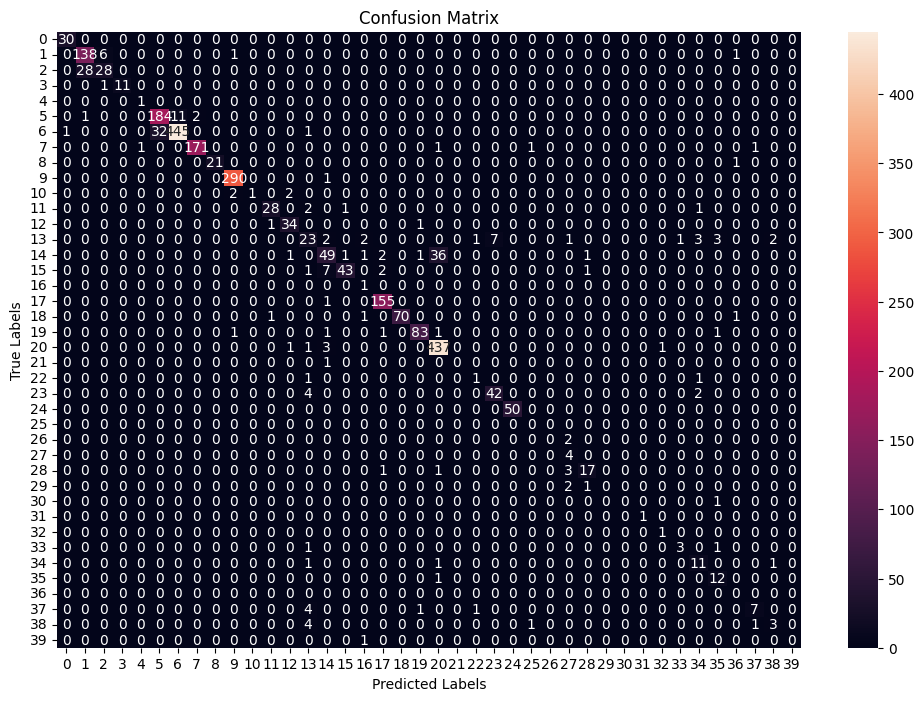

In [50]:
#Visualize the results
import seaborn as sns

from sklearn.metrics import confusion_matrix

cmat = confusion_matrix(Y_test.cpu(), Y_pred.cpu())
plt.figure(figsize=(12, 8))
sns.heatmap(cmat, annot=True, fmt="d")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


print()
print()


##ResNet - 18

In [56]:
import torch
import torch.nn as nn

class ResNet18(nn.Module):
    def __init__(self, num_classes=54):
        super(ResNet18, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Layer 1
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        # Layer 2
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        # Layer 3
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        # Layer 4
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [57]:
model = ResNet18().to(device)
print(model)

from torchsummary import summary
resnet_model = ResNet18(num_classes=54).to(device)

print(resnet_model)
summary(resnet_model, (3, 40, 40))

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

In [58]:
def train_model(resnet_model,epochs_no,train_loader,test_loader,val_loader,optimizer,criterion):

    for epoch in range(epochs_no):

        train_pred=[]
        vald_pred=[]
        total_length=0

        total_training_loss=0.0
        resnet_model.train()
        for data in train_loader:
            inputs,target = data
            inputs,target = inputs.to(device),target.to(device)
            optimizer.zero_grad()
            outputs = resnet_model(inputs)
            Prob = nn.Softmax(dim=1)(outputs)
            Y_pred = Prob.argmax(1).int()
            train_pred.append(accuracy(Y_pred,target).item())
            loss = criterion(outputs,target)
            loss.backward()
            optimizer.step()
            total_training_loss += loss.item()
            batch_length = target.size(0)
            total_length += batch_length
        total_training_loss/= total_length


        total_length =0

        resnet_model.to(device)
        resnet_model.eval()
        total_validation_loss = 0.0
        with torch.no_grad():
            for data in val_loader:
                inputs,target = data
                inputs,target = inputs.to(device),target.to(device)
                outputs = resnet_model(inputs)
                Prob = nn.Softmax(dim=1)(outputs)
                Y_pred = Prob.argmax(1).int()
                vald_pred.append(accuracy(Y_pred,target).item())
                val_loss = criterion(outputs, target)
                total_validation_loss += val_loss.item()
                batch_length = target.size(0)
                total_length += batch_length
        total_validation_loss/= total_length

        training_acc_data.append(sum(train_pred)/len(train_pred))
        val_acc_data.append(sum(vald_pred)/len(vald_pred))

        training_loss_data.append(total_training_loss)
        val_loss_data.append(total_validation_loss)

        print(f'Epoch: {epoch}, Loss: {loss}, val_loss:{total_validation_loss}')

    return training_loss_data, val_loss_data,training_acc_data,val_acc_data



In [59]:
import torch.optim as optim
from sklearn.metrics import precision_recall_fscore_support
from torchmetrics import Accuracy
import time

accuracy = Accuracy(task = "multiclass", num_classes=54).to(device)

training_loss_data =[]
val_loss_data =[]

training_acc_data =[]
val_acc_data =[]

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(),lr=0.001)
epoch_no = 20

training_loss_data,val_loss_data,training_acc_data,val_acc_data = train_model(resnet_model,epoch_no,train_loader,test_loader,val_loader,optimizer,criterion)


Epoch: 0, Loss: 0.4451233744621277, val_loss:0.006849027095205846
Epoch: 1, Loss: 0.2778583765029907, val_loss:0.005854819566975721
Epoch: 2, Loss: 0.15196120738983154, val_loss:0.005355454078011518
Epoch: 3, Loss: 0.5757318139076233, val_loss:0.004546703170200787
Epoch: 4, Loss: 0.15149083733558655, val_loss:0.004264290917836353
Epoch: 5, Loss: 0.09039502590894699, val_loss:0.0033470330744638593
Epoch: 6, Loss: 0.07937939465045929, val_loss:0.0034621219399949194
Epoch: 7, Loss: 0.06771226227283478, val_loss:0.00387611987759144
Epoch: 8, Loss: 0.1209254264831543, val_loss:0.004288482624040523
Epoch: 9, Loss: 0.3700297176837921, val_loss:0.003913085080958338
Epoch: 10, Loss: 0.1386510580778122, val_loss:0.002996744829733251
Epoch: 11, Loss: 0.2170950025320053, val_loss:0.003317644929872818
Epoch: 12, Loss: 0.09872879832983017, val_loss:0.0037588664948469477
Epoch: 13, Loss: 0.07303241640329361, val_loss:0.004767507056946373
Epoch: 14, Loss: 0.05223508179187775, val_loss:0.00377693667781

In [60]:
start_time = time.time()

testing_loss_data = []
testing_acc_data = []

for epoch in range(epoch_no):

    total_testing_loss = 0.0
    testing_pred=[]
    predictions =[]
    Y_test =[]
    total_length = 0

    resnet_model.to(device)
    resnet_model.eval()
    with torch.no_grad():
        for data in test_loader:
            inputs,target = data
            inputs,target = inputs.to(device),target.to(device)
            outputs = resnet_model(inputs)
            Prob = nn.Softmax(dim=1)(outputs)
            Y_pred = Prob.argmax(1).int()
            predictions.append(Y_pred)
            Y_test.append(target)
            testing_pred.append(accuracy(Y_pred,target).item())
            test_loss = criterion(outputs, target)
            total_testing_loss += test_loss.item()
            batch_length = target.size(0)
            total_length += batch_length
        total_testing_loss/= total_length

    testing_acc_data.append(sum(testing_pred)/len(testing_pred))
    testing_loss_data.append(total_testing_loss)

Y_pred1 = predictions
Y_test1 = Y_test
Y_pred = torch.cat(predictions)
Y_test = torch.cat(Y_test)
Final_accuracy = accuracy(Y_pred,Y_test).item()
precision,recall,f1, support = precision_recall_fscore_support(Y_test.cpu(),Y_pred.cpu())
training_time = time.time() - start_time

print("Performance Metrics:")
print(f"Time to Train : {training_time} seconds")
print(f"Accuracy      : {Final_accuracy*100:.2f} %")
print(f"Precison      : {precision} ")
print(f"Recall        : {recall} ")
print(f"F1 Score      : {f1} ")
print()
print()

Performance Metrics:
Time to Train : 3.6666910648345947 seconds
Accuracy      : 92.46 %
Precison      : [0.96774194 0.81290323 0.63265306 0.92307692 0.5        0.86363636
 0.96529284 0.95604396 1.         0.97979798 1.         0.96551724
 0.85365854 0.69387755 0.82608696 0.95918367 0.5        0.97452229
 0.98611111 0.98823529 0.92765957 0.         1.         0.
 0.95348837 1.         1.         1.         1.         1.
 1.         1.         1.         1.         0.9        1.
 0.70588235 0.6        0.        ] 
Recall        : [1.         0.8630137  0.55357143 1.         1.         0.95959596
 0.92901879 0.99428571 0.77272727 1.         0.2        0.875
 0.97222222 0.75555556 0.61956522 0.87037037 1.         0.98076923
 0.97260274 0.95454545 0.98419865 0.         1.         0.
 0.85416667 0.98       1.         1.         0.95454545 1.
 1.         1.         1.         0.8        0.64285714 0.76923077
 0.92307692 0.33333333 0.        ] 
F1 Score      : [0.98360656 0.8372093  0.59047619

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [61]:

print("Accuracy and Loss values:")
print()
print(f"Training Accuracy : {(sum(training_acc_data)/len(training_acc_data))*100:.2f} %")
print(f"Validation Accuracy : {(sum(val_acc_data)/len(val_acc_data))*100:.2f} %")
print(f"Testing Accuracy : {(sum(testing_acc_data)/len(testing_acc_data))*100:.2f} %")
print()
print(f"Training Loss : {(sum(training_loss_data)/len(training_loss_data))}")
print(f"Validation Loss : {(sum(val_loss_data)/len(val_loss_data))}")
print(f"Testing Loss : {(sum(testing_loss_data)/len(testing_loss_data))}")


Accuracy and Loss values:

Training Accuracy : 94.50 %
Validation Accuracy : 91.96 %
Testing Accuracy : 92.63 %

Training Loss : 0.002606591676466922
Validation Loss : 0.004131347229323817
Testing Loss : 0.0057093963950520625


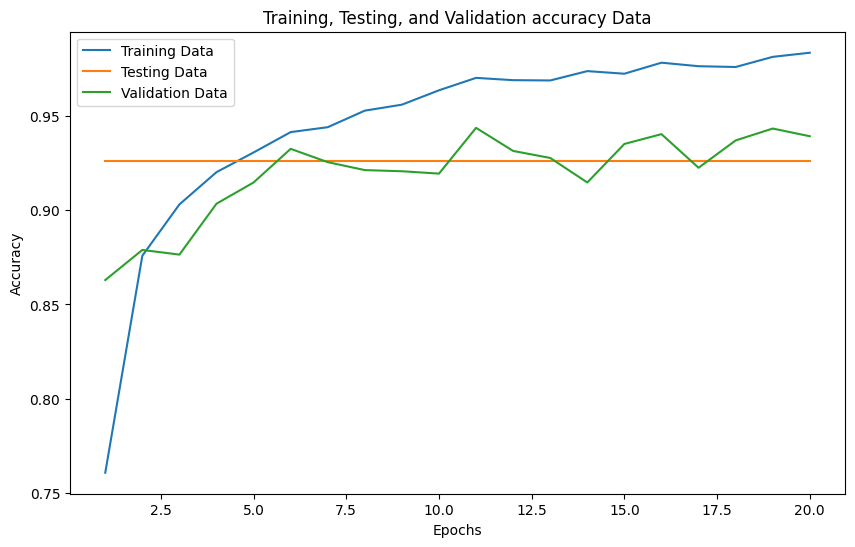

In [62]:
epochs = range(1,epoch_no+1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, training_acc_data, label='Training Data')
plt.plot(epochs, testing_acc_data, label='Testing Data')
plt.plot(epochs, val_acc_data, label='Validation Data')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training, Testing, and Validation accuracy Data')
plt.legend()
plt.show()


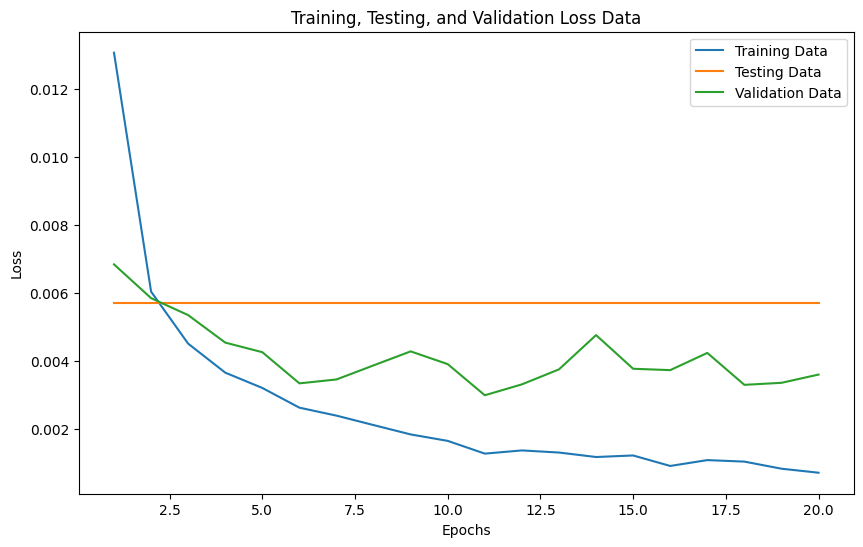

In [63]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss_data, label='Training Data')
plt.plot(epochs, testing_loss_data, label='Testing Data')
plt.plot(epochs, val_loss_data, label='Validation Data')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Testing, and Validation Loss Data')
plt.legend()
plt.show()

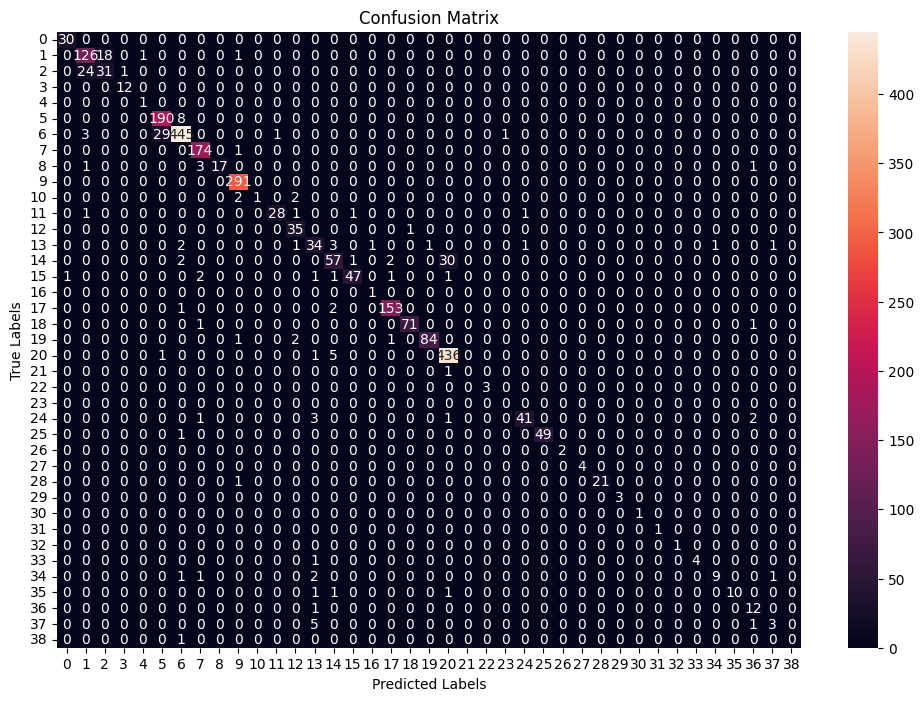

In [64]:
#Visualize the results

import seaborn as sns

from sklearn.metrics import confusion_matrix

cmat = confusion_matrix(Y_test.cpu(), Y_pred.cpu())
plt.figure(figsize=(12, 8))
sns.heatmap(cmat, annot=True, fmt="d")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


print()
print()


Hyperparamter Tuning

##Model 1 - Regularization

In [69]:
import torch
import torch.nn as nn

class ResNet18(nn.Module):
    def __init__(self, num_classes=54):
        super(ResNet18, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Layer 1
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        # Layer 2
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        # Layer 3
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        # Layer 4
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [70]:
from torchsummary import summary
resnet_model1 = ResNet18(num_classes=54).to(device)

print(resnet_model1)
summary(resnet_model1, (3, 40, 40))

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

In [71]:
def train_model(resnet_model1,epochs_no,train_loader,test_loader,val_loader,optimizer,criterion):

    for epoch in range(epochs_no):

        train_pred=[]
        vald_pred=[]
        total_length=0

        total_training_loss=0.0
        resnet_model1.train()
        for data in train_loader:
            inputs,target = data
            inputs,target = inputs.to(device),target.to(device)
            optimizer.zero_grad()
            outputs = resnet_model1(inputs)
            Prob = nn.Softmax(dim=1)(outputs)
            Y_pred = Prob.argmax(1).int()
            train_pred.append(accuracy(Y_pred,target).item())
            loss = criterion(outputs,target)
            loss.backward()
            optimizer.step()
            total_training_loss += loss.item()
            batch_length = target.size(0)
            total_length += batch_length
        total_training_loss/= total_length


        total_length =0

        resnet_model1.to(device)
        resnet_model1.eval()
        total_validation_loss = 0.0
        with torch.no_grad():
            for data in val_loader:
                inputs,target = data
                inputs,target = inputs.to(device),target.to(device)
                outputs = resnet_model(inputs)
                Prob = nn.Softmax(dim=1)(outputs)
                Y_pred = Prob.argmax(1).int()
                vald_pred.append(accuracy(Y_pred,target).item())
                val_loss = criterion(outputs, target)
                total_validation_loss += val_loss.item()
                batch_length = target.size(0)
                total_length += batch_length
        total_validation_loss/= total_length

        training_acc_data.append(sum(train_pred)/len(train_pred))
        val_acc_data.append(sum(vald_pred)/len(vald_pred))

        training_loss_data.append(total_training_loss)
        val_loss_data.append(total_validation_loss)

        print(f'Epoch: {epoch}, Loss: {loss}, val_loss:{total_validation_loss}')

    return training_loss_data, val_loss_data,training_acc_data,val_acc_data


In [72]:
import torch.optim as optim
from sklearn.metrics import precision_recall_fscore_support
from torchmetrics import Accuracy
import time

accuracy = Accuracy(task = "multiclass", num_classes=54).to(device)

training_loss_data =[]
val_loss_data =[]

training_acc_data =[]
val_acc_data =[]

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model1.parameters(),lr=0.001, weight_decay= 1e-5)
epoch_no = 20

training_loss_data,val_loss_data,training_acc_data,val_acc_data = train_model(resnet_model1,epoch_no,train_loader,test_loader,val_loader,optimizer,criterion)

Epoch: 0, Loss: 0.5029376745223999, val_loss:0.0036056143378167395
Epoch: 1, Loss: 0.3419199287891388, val_loss:0.0036282430913088027
Epoch: 2, Loss: 0.2096475064754486, val_loss:0.003605591727762268
Epoch: 3, Loss: 0.2939598560333252, val_loss:0.0037061914895190726
Epoch: 4, Loss: 0.24657554924488068, val_loss:0.003605600608363767
Epoch: 5, Loss: 0.2336796373128891, val_loss:0.003874518941530584
Epoch: 6, Loss: 0.28526899218559265, val_loss:0.004671600300196145
Epoch: 7, Loss: 0.20038503408432007, val_loss:0.003605737906767585
Epoch: 8, Loss: 0.30394694209098816, val_loss:0.0036056224770762797
Epoch: 9, Loss: 0.18705801665782928, val_loss:0.0036055956136920248
Epoch: 10, Loss: 0.1686938852071762, val_loss:0.0036097162650975383
Epoch: 11, Loss: 0.1271851807832718, val_loss:0.003605592002042172
Epoch: 12, Loss: 0.17151860892772675, val_loss:0.0036059489065914537
Epoch: 13, Loss: 0.16391302645206451, val_loss:0.0036063155844108514
Epoch: 14, Loss: 0.057466667145490646, val_loss:0.0036056

In [73]:
start_time = time.time()

testing_loss_data = []
testing_acc_data = []

for epoch in range(epoch_no):

    total_testing_loss = 0.0
    testing_pred=[]
    predictions =[]
    Y_test =[]
    total_length = 0

    resnet_model1.to(device)
    resnet_model1.eval()
    with torch.no_grad():
        for data in test_loader:
            inputs,target = data
            inputs,target = inputs.to(device),target.to(device)
            outputs = resnet_model1(inputs)
            Prob = nn.Softmax(dim=1)(outputs)
            Y_pred = Prob.argmax(1).int()
            predictions.append(Y_pred)
            Y_test.append(target)
            testing_pred.append(accuracy(Y_pred,target).item())
            test_loss = criterion(outputs, target)
            total_testing_loss += test_loss.item()
            batch_length = target.size(0)
            total_length += batch_length
        total_testing_loss/= total_length

    testing_acc_data.append(sum(testing_pred)/len(testing_pred))
    testing_loss_data.append(total_testing_loss)

Y_pred1 = predictions
Y_test1 = Y_test
Y_pred = torch.cat(predictions)
Y_test = torch.cat(Y_test)
Final_accuracy = accuracy(Y_pred,Y_test).item()
precision,recall,f1, support = precision_recall_fscore_support(Y_test.cpu(),Y_pred.cpu())
training_time = time.time() - start_time

print("Performance Metrics:")
print(f"Time to Train : {training_time} seconds")
print(f"Accuracy      : {Final_accuracy*100:.2f} %")
print(f"Precison      : {precision} ")
print(f"Recall        : {recall} ")
print(f"F1 Score      : {f1} ")
print()
print()

Performance Metrics:
Time to Train : 3.4636716842651367 seconds
Accuracy      : 92.35 %
Precison      : [1.         0.84137931 0.61111111 0.92307692 0.5        0.87317073
 0.95387841 0.98295455 0.95238095 0.97324415 1.         1.
 0.89189189 0.66       0.80597015 0.97959184 1.         0.99358974
 0.97222222 1.         0.91983122 0.         0.75       0.
 0.91836735 1.         0.66666667 1.         0.95238095 0.66666667
 0.         1.         0.33333333 1.         0.81818182 1.
 0.75       0.6        0.        ] 
Recall        : [1.         0.83561644 0.58928571 1.         1.         0.9040404
 0.94989562 0.98857143 0.90909091 1.         0.2        0.875
 0.91666667 0.73333333 0.58695652 0.88888889 1.         0.99358974
 0.95890411 0.96590909 0.98419865 0.         1.         0.
 0.9375     0.96       1.         0.75       0.90909091 0.66666667
 0.         1.         1.         0.8        0.64285714 0.92307692
 0.92307692 0.33333333 0.        ] 
F1 Score      : [1.         0.83848797 0.6

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [74]:
print("Accuracy and Loss values:")
print()
print(f"Training Accuracy : {(sum(training_acc_data)/len(training_acc_data))*100:.2f} %")
print(f"Validation Accuracy : {(sum(val_acc_data)/len(val_acc_data))*100:.2f} %")
print(f"Testing Accuracy : {(sum(testing_acc_data)/len(testing_acc_data))*100:.2f} %")
print()
print(f"Training Loss : {(sum(training_loss_data)/len(training_loss_data))}")
print(f"Validation Loss : {(sum(val_loss_data)/len(val_loss_data))}")
print(f"Testing Loss : {(sum(testing_loss_data)/len(testing_loss_data))}")

Accuracy and Loss values:

Training Accuracy : 94.23 %
Validation Accuracy : 93.82 %
Testing Accuracy : 92.52 %

Training Loss : 0.002725921769144628
Validation Loss : 0.0036790819434149775
Testing Loss : 0.0046278628150408325


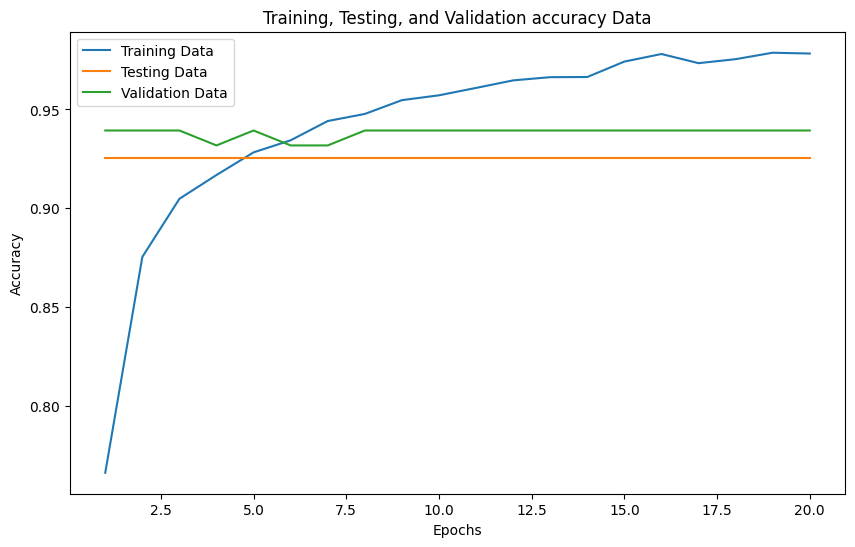

In [75]:
epochs = range(1,epoch_no+1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, training_acc_data, label='Training Data')
plt.plot(epochs, testing_acc_data, label='Testing Data')
plt.plot(epochs, val_acc_data, label='Validation Data')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training, Testing, and Validation accuracy Data')
plt.legend()
plt.show()

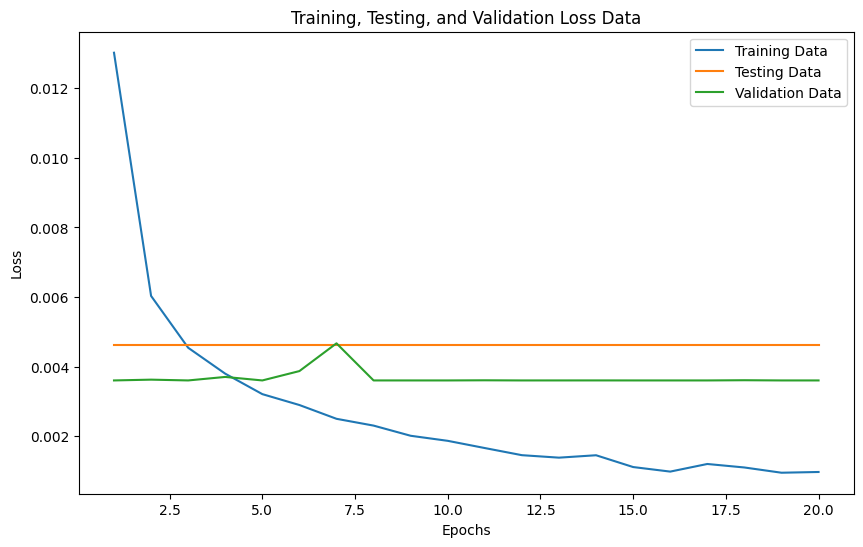

In [76]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss_data, label='Training Data')
plt.plot(epochs, testing_loss_data, label='Testing Data')
plt.plot(epochs, val_loss_data, label='Validation Data')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Testing, and Validation Loss Data')
plt.legend()
plt.show()

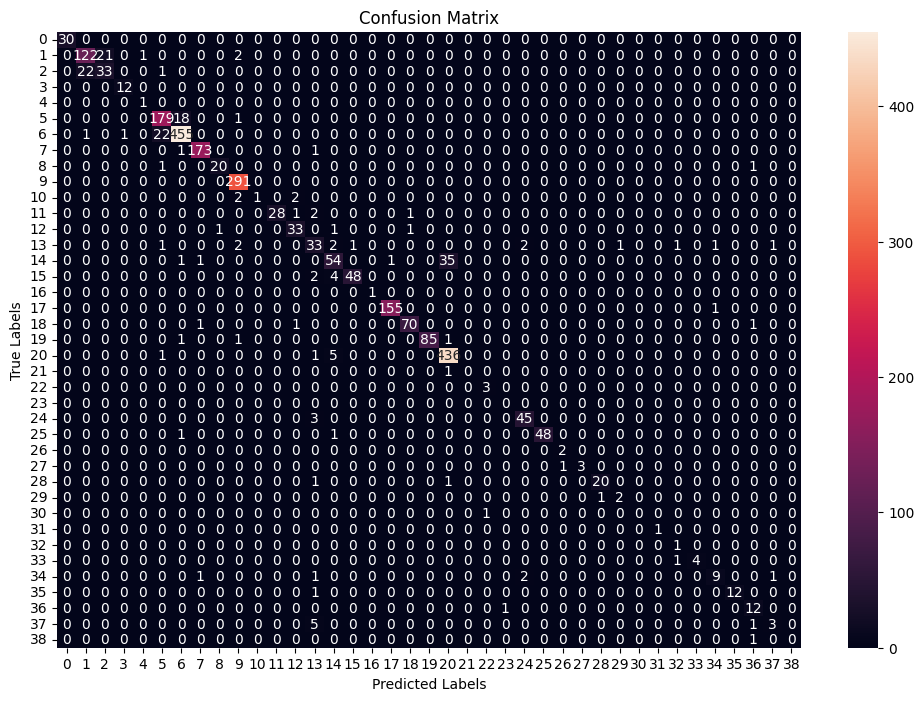

In [77]:
#Visualize the results
import seaborn as sns

from sklearn.metrics import confusion_matrix

cmat = confusion_matrix(Y_test.cpu(), Y_pred.cpu())
plt.figure(figsize=(12, 8))
sns.heatmap(cmat, annot=True, fmt="d")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


print()
print()


##Model - 2
Early Stopping

In [78]:
import torch
import torch.nn as nn

class ResNet18(nn.Module):
    def __init__(self, num_classes=54):
        super(ResNet18, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Layer 1
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        # Layer 2
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        # Layer 3
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        # Layer 4
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


In [79]:
from torchsummary import summary
resnet_model2 = ResNet18(num_classes=54).to(device)

print(resnet_model2)
summary(resnet_model2, (3, 40, 40))

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

In [80]:
def train_model(resnet_model2,epochs_no,train_loader,test_loader,val_loader,optimizer,criterion):

    early_stopping_patience = 5
    best_validation_loss = float('inf')
    consecutive_increases = 0

    for epoch in range(epochs_no):

        train_pred=[]
        vald_pred=[]
        total_length=0

        total_training_loss=0.0
        resnet_model2.train()
        for data in train_loader:
            inputs,target = data
            inputs,target = inputs.to(device),target.to(device)
            optimizer.zero_grad()
            outputs = resnet_model2(inputs)
            Prob = nn.Softmax(dim=1)(outputs)
            Y_pred = Prob.argmax(1).int()
            train_pred.append(accuracy(Y_pred,target).item())
            loss = criterion(outputs,target)
            loss.backward()
            optimizer.step()
            total_training_loss += loss.item()
            batch_length = target.size(0)
            total_length += batch_length
        total_training_loss/= total_length


        total_length =0

        resnet_model2.to(device)
        resnet_model2.eval()
        total_validation_loss = 0.0
        with torch.no_grad():
            for data in val_loader:
                inputs,target = data
                inputs,target = inputs.to(device),target.to(device)
                outputs = resnet_model(inputs)
                Prob = nn.Softmax(dim=1)(outputs)
                Y_pred = Prob.argmax(1).int()
                vald_pred.append(accuracy(Y_pred,target).item())
                val_loss = criterion(outputs, target)
                total_validation_loss += val_loss.item()
                batch_length = target.size(0)
                total_length += batch_length
        total_validation_loss/= total_length

        training_acc_data.append(sum(train_pred)/len(train_pred))
        val_acc_data.append(sum(vald_pred)/len(vald_pred))

        training_loss_data.append(total_training_loss)
        val_loss_data.append(total_validation_loss)

        print(f'Epoch: {epoch}, Loss: {loss}, val_loss:{total_validation_loss}')

        if total_validation_loss < best_validation_loss:
           best_validation_loss = total_validation_loss
           consecutive_increases = 0
        else:
           consecutive_increases += 1

        if consecutive_increases >= early_stopping_patience:
           print("Early stopping!")
           break

    return training_loss_data, val_loss_data,training_acc_data,val_acc_data,epoch


In [81]:
import torch.optim as optim
from sklearn.metrics import precision_recall_fscore_support
from torchmetrics import Accuracy
import time

accuracy = Accuracy(task = "multiclass", num_classes=54).to(device)

training_loss_data =[]
val_loss_data =[]

training_acc_data =[]
val_acc_data =[]

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model2.parameters(),lr=0.001, weight_decay= 1e-5)
epoch_no = 100

training_loss_data,val_loss_data,training_acc_data,val_acc_data,epoch = train_model(resnet_model2,epoch_no,train_loader,test_loader,val_loader,optimizer,criterion)

Epoch: 0, Loss: 1.217881679534912, val_loss:0.003606476677070451
Epoch: 1, Loss: 0.19151006639003754, val_loss:0.0036056754794002352
Epoch: 2, Loss: 0.16996431350708008, val_loss:0.004521676725635272
Epoch: 3, Loss: 0.2563747763633728, val_loss:0.0036063029138859878
Epoch: 4, Loss: 0.3734110891819, val_loss:0.003605991789218865
Epoch: 5, Loss: 0.11999211460351944, val_loss:0.0036278657741393707
Epoch: 6, Loss: 0.06562741100788116, val_loss:0.0036055914605739644
Epoch: 7, Loss: 0.17331846058368683, val_loss:0.0036685458775489194
Epoch: 8, Loss: 0.05387045070528984, val_loss:0.0036099008988230274
Epoch: 9, Loss: 0.3270658254623413, val_loss:0.003605887162399687
Epoch: 10, Loss: 0.10105302184820175, val_loss:0.0036103085178327415
Epoch: 11, Loss: 0.10563100129365921, val_loss:0.003615896775184088
Early stopping!


In [82]:
start_time = time.time()

testing_loss_data = []
testing_acc_data = []

epoch_no = epoch +1

for epoch in range(epoch_no):

    total_testing_loss = 0.0
    testing_pred=[]
    predictions =[]
    Y_test =[]
    total_length = 0

    resnet_model2.to(device)
    resnet_model2.eval()
    with torch.no_grad():
        for data in test_loader:
            inputs,target = data
            inputs,target = inputs.to(device),target.to(device)
            outputs = resnet_model2(inputs)
            Prob = nn.Softmax(dim=1)(outputs)
            Y_pred = Prob.argmax(1).int()
            predictions.append(Y_pred)
            Y_test.append(target)
            testing_pred.append(accuracy(Y_pred,target).item())
            test_loss = criterion(outputs, target)
            total_testing_loss += test_loss.item()
            batch_length = target.size(0)
            total_length += batch_length
        total_testing_loss/= total_length

    testing_acc_data.append(sum(testing_pred)/len(testing_pred))
    testing_loss_data.append(total_testing_loss)

Y_pred1 = predictions
Y_test1 = Y_test
Y_pred = torch.cat(predictions)
Y_test = torch.cat(Y_test)
Final_accuracy = accuracy(Y_pred,Y_test).item()
precision,recall,f1, support = precision_recall_fscore_support(Y_test.cpu(),Y_pred.cpu())
training_time = time.time() - start_time

print("Performance Metrics:")
print(f"Time to Train : {training_time} seconds")
print(f"Accuracy      : {Final_accuracy*100:.2f} %")
print(f"Precison      : {precision} ")
print(f"Recall        : {recall} ")
print(f"F1 Score      : {f1} ")
print()
print()

Performance Metrics:
Time to Train : 2.164909601211548 seconds
Accuracy      : 92.50 %
Precison      : [0.9375     0.85430464 0.75       0.92307692 0.33333333 0.94535519
 0.94354839 0.98305085 0.85714286 0.98644068 0.33333333 0.83783784
 0.91666667 0.57894737 0.92307692 0.86440678 0.5        1.
 1.         0.93406593 0.91268191 0.         0.75       0.97619048
 1.         0.4        1.         0.86956522 0.75       0.
 1.         0.         1.         1.         1.         0.66666667
 0.66666667 0.        ] 
Recall        : [1.         0.88356164 0.58928571 1.         1.         0.87373737
 0.97703549 0.99428571 0.81818182 1.         0.2        0.96875
 0.91666667 0.73333333 0.52173913 0.94444444 1.         0.96794872
 0.97260274 0.96590909 0.99097065 0.         1.         0.85416667
 0.98       1.         0.75       0.90909091 1.         0.
 1.         0.         0.2        0.71428571 0.84615385 0.76923077
 0.22222222 0.        ] 
F1 Score      : [0.96774194 0.86868687 0.66       0.96

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [83]:
print("Accuracy and Loss values:")
print()
print(f"Training Accuracy : {(sum(training_acc_data)/len(training_acc_data))*100:.2f} %")
print(f"Validation Accuracy : {(sum(val_acc_data)/len(val_acc_data))*100:.2f} %")
print(f"Testing Accuracy : {(sum(testing_acc_data)/len(testing_acc_data))*100:.2f} %")
print()
print(f"Training Loss : {(sum(training_loss_data)/len(training_loss_data))}")
print(f"Validation Loss : {(sum(val_loss_data)/len(val_loss_data))}")
print(f"Testing Loss : {(sum(testing_loss_data)/len(testing_loss_data))}")

Accuracy and Loss values:

Training Accuracy : 92.39 %
Validation Accuracy : 93.87 %
Testing Accuracy : 92.67 %

Training Loss : 0.0036520915816178443
Validation Loss : 0.003690843337642718
Testing Loss : 0.004095952242885213


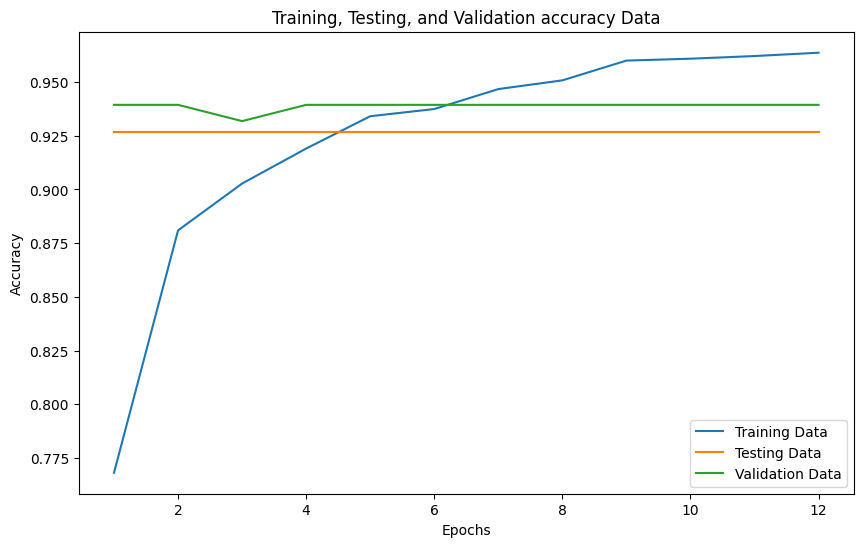

In [84]:
epochs = range(1,epoch_no+1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, training_acc_data, label='Training Data')
plt.plot(epochs, testing_acc_data, label='Testing Data')
plt.plot(epochs, val_acc_data, label='Validation Data')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training, Testing, and Validation accuracy Data')
plt.legend()
plt.show()

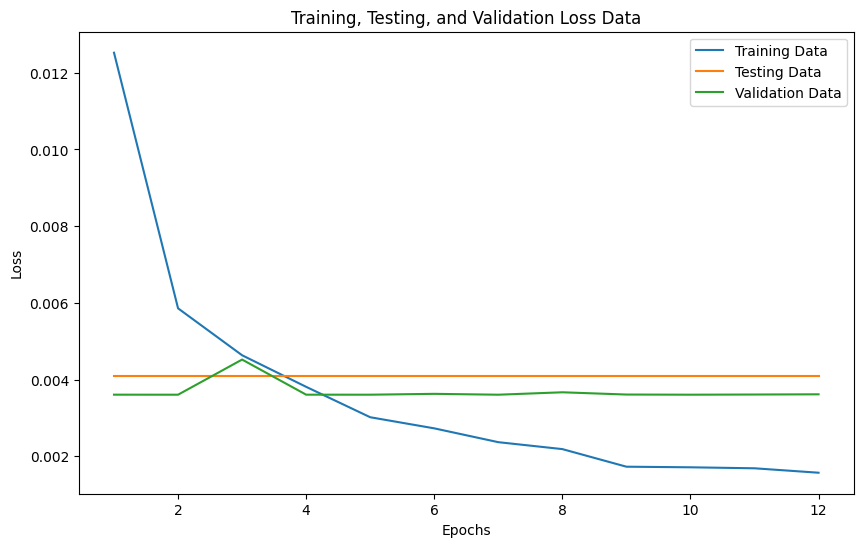

In [85]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss_data, label='Training Data')
plt.plot(epochs, testing_loss_data, label='Testing Data')
plt.plot(epochs, val_loss_data, label='Validation Data')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Testing, and Validation Loss Data')
plt.legend()
plt.show()

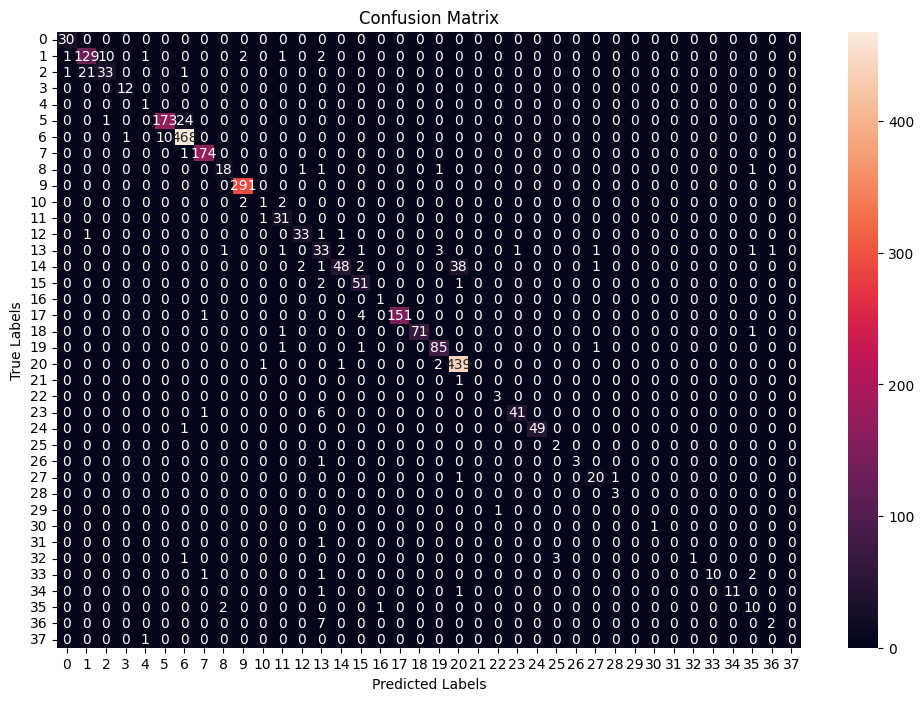

In [87]:
#Visualize the results
import seaborn as sns

from sklearn.metrics import confusion_matrix

cmat = confusion_matrix(Y_test.cpu(), Y_pred.cpu())
plt.figure(figsize=(12, 8))
sns.heatmap(cmat, annot=True, fmt="d")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


print()
print()


## Model 3

Changing the optimizer to SGD


In [91]:
import torch
import torch.nn as nn

class ResNet18(nn.Module):
    def __init__(self, num_classes=54):
        super(ResNet18, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Layer 1
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        # Layer 2
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        # Layer 3
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        # Layer 4
        self.layer4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


In [92]:
from torchsummary import summary
resnet_model3 = ResNet18(num_classes=54).to(device)

print(resnet_model3)
summary(resnet_model3, (3, 40, 40))

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

In [93]:
def train_model(resnet_model3,epochs_no,train_loader,test_loader,val_loader,optimizer,criterion):

    early_stopping_patience = 5
    best_validation_loss = float('inf')
    consecutive_increases = 0

    for epoch in range(epochs_no):

        train_pred=[]
        vald_pred=[]
        total_length=0

        total_training_loss=0.0
        resnet_model3.train()
        for data in train_loader:
            inputs,target = data
            inputs,target = inputs.to(device),target.to(device)
            optimizer.zero_grad()
            outputs = resnet_model3(inputs)
            Prob = nn.Softmax(dim=1)(outputs)
            Y_pred = Prob.argmax(1).int()
            train_pred.append(accuracy(Y_pred,target).item())
            loss = criterion(outputs,target)
            loss.backward()
            optimizer.step()
            total_training_loss += loss.item()
            batch_length = target.size(0)
            total_length += batch_length
        total_training_loss/= total_length


        total_length =0

        resnet_model3.to(device)
        resnet_model3.eval()
        total_validation_loss = 0.0
        with torch.no_grad():
            for data in val_loader:
                inputs,target = data
                inputs,target = inputs.to(device),target.to(device)
                outputs = resnet_model3(inputs)
                Prob = nn.Softmax(dim=1)(outputs)
                Y_pred = Prob.argmax(1).int()
                vald_pred.append(accuracy(Y_pred,target).item())
                val_loss = criterion(outputs, target)
                total_validation_loss += val_loss.item()
                batch_length = target.size(0)
                total_length += batch_length
        total_validation_loss/= total_length

        training_acc_data.append(sum(train_pred)/len(train_pred))
        val_acc_data.append(sum(vald_pred)/len(vald_pred))

        training_loss_data.append(total_training_loss)
        val_loss_data.append(total_validation_loss)

        print(f'Epoch: {epoch}, Loss: {loss}, val_loss:{total_validation_loss}')

        if total_validation_loss < best_validation_loss:
           best_validation_loss = total_validation_loss
           consecutive_increases = 0
        else:
           consecutive_increases += 1

        if consecutive_increases >= early_stopping_patience:
           print("Early stopping!")
           break

    return training_loss_data, val_loss_data,training_acc_data,val_acc_data,epoch


In [94]:
import torch.optim as optim
from sklearn.metrics import precision_recall_fscore_support
from torchmetrics import Accuracy
import time

accuracy = Accuracy(task = "multiclass", num_classes=54).to(device)

training_loss_data =[]
val_loss_data =[]

training_acc_data =[]
val_acc_data =[]

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet_model3.parameters(),lr=0.001, weight_decay= 1e-5)
epoch_no = 100

training_loss_data,val_loss_data,training_acc_data,val_acc_data,epoch = train_model(resnet_model3,epoch_no,train_loader,test_loader,val_loader,optimizer,criterion)

Epoch: 0, Loss: 2.322192430496216, val_loss:0.03762888028043552
Epoch: 1, Loss: 1.827534794807434, val_loss:0.02732352058743178
Epoch: 2, Loss: 1.357239007949829, val_loss:0.02149664277943269
Epoch: 3, Loss: 0.80815190076828, val_loss:0.01711215712427866
Epoch: 4, Loss: 0.918038010597229, val_loss:0.015060859281026595
Epoch: 5, Loss: 0.7878519892692566, val_loss:0.013361198795717571
Epoch: 6, Loss: 0.7169462442398071, val_loss:0.012316915226109726
Epoch: 7, Loss: 0.66572505235672, val_loss:0.011208805524672126
Epoch: 8, Loss: 0.9217885732650757, val_loss:0.01016492866260451
Epoch: 9, Loss: 0.6131958365440369, val_loss:0.01005844317509913
Epoch: 10, Loss: 0.48542457818984985, val_loss:0.008797687336201218
Epoch: 11, Loss: 0.48462042212486267, val_loss:0.008264978456324755
Epoch: 12, Loss: 0.5344567894935608, val_loss:0.008092546944024675
Epoch: 13, Loss: 0.35141006112098694, val_loss:0.007472275519125989
Epoch: 14, Loss: 0.5902107954025269, val_loss:0.007046415131265417
Epoch: 15, Loss:

In [95]:
start_time = time.time()

testing_loss_data = []
testing_acc_data = []

epoch_no = epoch +1

for epoch in range(epoch_no):

    total_testing_loss = 0.0
    testing_pred=[]
    predictions =[]
    Y_test =[]
    total_length = 0

    resnet_model3.to(device)
    resnet_model3.eval()
    with torch.no_grad():
        for data in test_loader:
            inputs,target = data
            inputs,target = inputs.to(device),target.to(device)
            outputs = resnet_model3(inputs)
            Prob = nn.Softmax(dim=1)(outputs)
            Y_pred = Prob.argmax(1).int()
            predictions.append(Y_pred)
            Y_test.append(target)
            testing_pred.append(accuracy(Y_pred,target).item())
            test_loss = criterion(outputs, target)
            total_testing_loss += test_loss.item()
            batch_length = target.size(0)
            total_length += batch_length
        total_testing_loss/= total_length

    testing_acc_data.append(sum(testing_pred)/len(testing_pred))
    testing_loss_data.append(total_testing_loss)

Y_pred1 = predictions
Y_test1 = Y_test
Y_pred = torch.cat(predictions)
Y_test = torch.cat(Y_test)
Final_accuracy = accuracy(Y_pred,Y_test).item()
precision,recall,f1, support = precision_recall_fscore_support(Y_test.cpu(),Y_pred.cpu())
training_time = time.time() - start_time

print("Performance Metrics:")
print(f"Time to Train : {training_time} seconds")
print(f"Accuracy      : {Final_accuracy*100:.2f} %")
print(f"Precison      : {precision} ")
print(f"Recall        : {recall} ")
print(f"F1 Score      : {f1} ")
print()
print()

Performance Metrics:
Time to Train : 11.548025608062744 seconds
Accuracy      : 92.99 %
Precison      : [1.         0.83435583 0.75555556 0.91666667 0.         0.9
 0.97441365 0.97765363 1.         0.98644068 0.         0.87878788
 0.83333333 0.63793103 0.82089552 0.90909091 0.         0.98726115
 1.         0.98850575 0.92340426 0.         0.         0.9375
 1.         0.         0.66666667 0.86956522 0.         0.
 0.         0.         0.         0.83333333 0.85714286 0.76923077
 0.         0.        ] 
Recall        : [1.         0.93150685 0.60714286 0.91666667 0.         0.95454545
 0.95407098 1.         0.81818182 1.         0.         0.90625
 0.97222222 0.82222222 0.59782609 0.92592593 0.         0.99358974
 0.95890411 0.97727273 0.97968397 0.         0.         0.9375
 0.98       0.         1.         0.90909091 0.         0.
 0.         0.         0.         0.71428571 0.92307692 0.76923077
 0.         0.        ] 
F1 Score      : [1.         0.8802589  0.67326733 0.91666667

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [96]:
print("Accuracy and Loss values:")
print()
print(f"Training Accuracy : {(sum(training_acc_data)/len(training_acc_data))*100:.2f} %")
print(f"Validation Accuracy : {(sum(val_acc_data)/len(val_acc_data))*100:.2f} %")
print(f"Testing Accuracy : {(sum(testing_acc_data)/len(testing_acc_data))*100:.2f} %")
print()
print(f"Training Loss : {(sum(training_loss_data)/len(training_loss_data))}")
print(f"Validation Loss : {(sum(val_loss_data)/len(val_loss_data))}")
print(f"Testing Loss : {(sum(testing_loss_data)/len(testing_loss_data))}")

Accuracy and Loss values:

Training Accuracy : 92.69 %
Validation Accuracy : 89.47 %
Testing Accuracy : 93.15 %

Training Loss : 0.005258712332275721
Validation Loss : 0.006696939058787605
Testing Loss : 0.004403668996405928


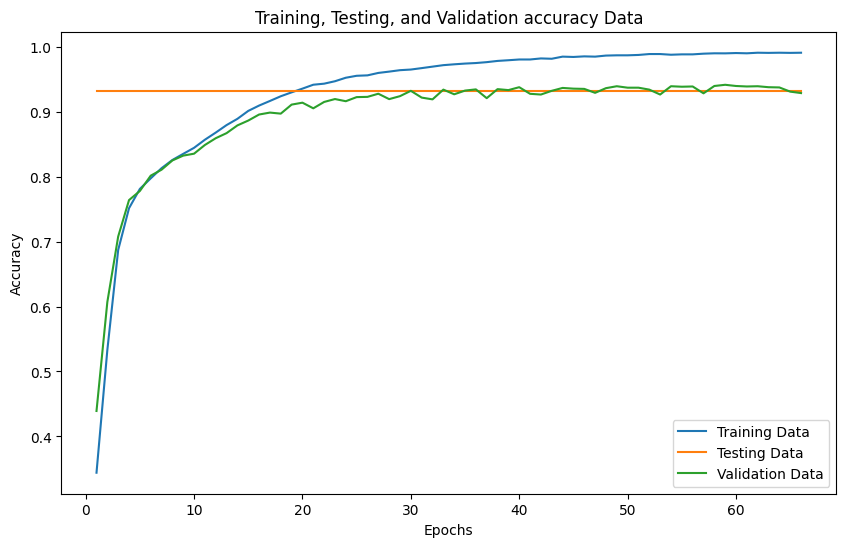

In [97]:
epochs = range(1,epoch_no+1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, training_acc_data, label='Training Data')
plt.plot(epochs, testing_acc_data, label='Testing Data')
plt.plot(epochs, val_acc_data, label='Validation Data')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training, Testing, and Validation accuracy Data')
plt.legend()
plt.show()

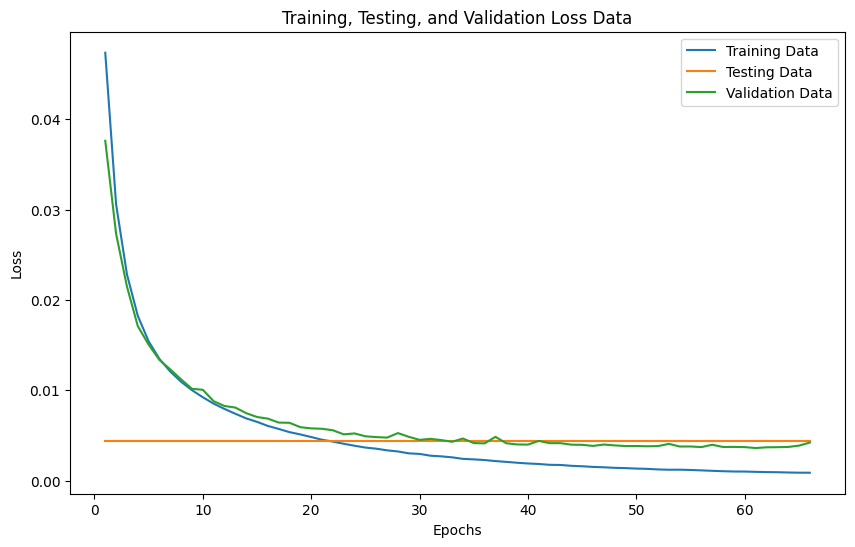

In [98]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss_data, label='Training Data')
plt.plot(epochs, testing_loss_data, label='Testing Data')
plt.plot(epochs, val_loss_data, label='Validation Data')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Testing, and Validation Loss Data')
plt.legend()
plt.show()

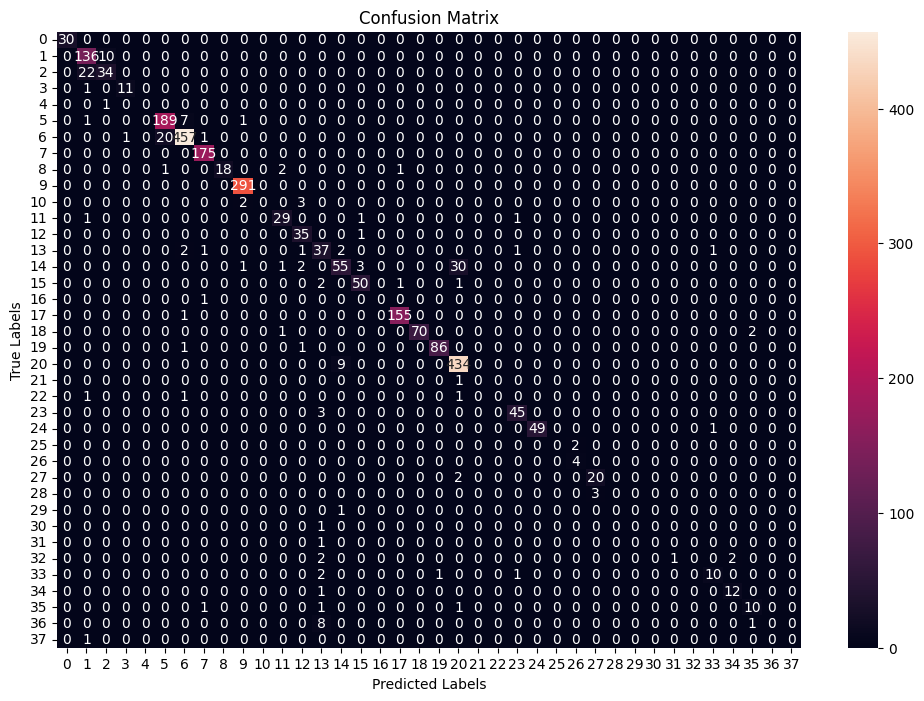

In [99]:
#Visualize the results
import seaborn as sns

from sklearn.metrics import confusion_matrix

cmat = confusion_matrix(Y_test.cpu(), Y_pred.cpu())
plt.figure(figsize=(12, 8))
sns.heatmap(cmat, annot=True, fmt="d")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


print()
print()


##Densenet (Pre Trained)

In [101]:
import torchvision.models as models

classes_num = 54
densenet_model = torchvision.models.densenet161(pretrained=True).to(device)
densenet_model.classifier = nn.Linear(densenet_model.classifier.in_features,classes_num).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(densenet_model.parameters(),lr=0.001,weight_decay=1e-9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:01<00:00, 69.8MB/s]


In [102]:
def train_model(densenet_model,epochs_no,train_loader,test_loader,val_loader,optimizer,criterion):

    for epoch in range(epochs_no):

        train_pred=[]
        vald_pred=[]
        total_length=0

        total_training_loss=0.0
        densenet_model.train()
        for data in train_loader:
            inputs,target = data
            inputs,target = inputs.to(device),target.to(device)
            optimizer.zero_grad()
            outputs = densenet_model(inputs)
            Prob = nn.Softmax(dim=1)(outputs)
            Y_pred = Prob.argmax(1).int()
            train_pred.append(accuracy(Y_pred,target).item())
            loss = criterion(outputs,target)
            loss.backward()
            optimizer.step()
            total_training_loss += loss.item()
            batch_length = target.size(0)
            total_length += batch_length
        total_training_loss/= total_length


        total_length =0

        densenet_model.to(device)
        densenet_model.eval()
        total_validation_loss = 0.0
        with torch.no_grad():
            for data in val_loader:
                inputs,target = data
                inputs,target = inputs.to(device),target.to(device)
                outputs = densenet_model(inputs)
                Prob = nn.Softmax(dim=1)(outputs)
                Y_pred = Prob.argmax(1).int()
                vald_pred.append(accuracy(Y_pred,target).item())
                val_loss = criterion(outputs, target)
                total_validation_loss += val_loss.item()
                batch_length = target.size(0)
                total_length += batch_length
        total_validation_loss/= total_length

        training_acc_data.append(sum(train_pred)/len(train_pred))
        val_acc_data.append(sum(vald_pred)/len(vald_pred))

        training_loss_data.append(total_training_loss)
        val_loss_data.append(total_validation_loss)

        print(f'Epoch: {epoch}, Loss: {loss}, val_loss:{total_validation_loss}')

    return training_loss_data, val_loss_data,training_acc_data,val_acc_data

In [103]:
import torch.optim as optim
from sklearn.metrics import precision_recall_fscore_support
from torchmetrics import Accuracy
import time

accuracy = Accuracy(task = "multiclass", num_classes=54).to(device)

training_loss_data =[]
val_loss_data =[]

training_acc_data =[]
val_acc_data =[]

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(densenet_model.parameters(),lr=0.001)
epoch_no = 20

training_loss_data,val_loss_data,training_acc_data,val_acc_data = train_model(densenet_model,epoch_no,train_loader,test_loader,val_loader,optimizer,criterion)

Epoch: 0, Loss: 0.4299314618110657, val_loss:0.010207132985485702
Epoch: 1, Loss: 0.302346795797348, val_loss:0.003958265227274519
Epoch: 2, Loss: 0.18292246758937836, val_loss:0.0038851153489796435
Epoch: 3, Loss: 0.12359138578176498, val_loss:0.0035038640390093172
Epoch: 4, Loss: 0.3153894245624542, val_loss:0.0029652046258084484
Epoch: 5, Loss: 0.08144636452198029, val_loss:0.0025569212858230664
Epoch: 6, Loss: 0.027649905532598495, val_loss:0.0025396206996537996
Epoch: 7, Loss: 0.12234575301408768, val_loss:0.002902976358837622
Epoch: 8, Loss: 0.03356091305613518, val_loss:0.002567557204297776
Epoch: 9, Loss: 0.04915402829647064, val_loss:0.0028025086528735417
Epoch: 10, Loss: 0.536561906337738, val_loss:0.0025671373858003107
Epoch: 11, Loss: 0.07119215279817581, val_loss:0.0030854985090968813
Epoch: 12, Loss: 0.08387462049722672, val_loss:0.0029991195173058437
Epoch: 13, Loss: 0.017692262306809425, val_loss:0.0025577054074827155
Epoch: 14, Loss: 0.020935477688908577, val_loss:0.00

In [104]:
start_time = time.time()

testing_loss_data = []
testing_acc_data = []

for epoch in range(epoch_no):

    total_testing_loss = 0.0
    testing_pred=[]
    predictions =[]
    Y_test =[]
    total_length = 0

    densenet_model.to(device)
    densenet_model.eval()
    with torch.no_grad():
        for data in test_loader:
            inputs,target = data
            inputs,target = inputs.to(device),target.to(device)
            outputs = densenet_model(inputs)
            Prob = nn.Softmax(dim=1)(outputs)
            Y_pred = Prob.argmax(1).int()
            predictions.append(Y_pred)
            Y_test.append(target)
            testing_pred.append(accuracy(Y_pred,target).item())
            test_loss = criterion(outputs, target)
            total_testing_loss += test_loss.item()
            batch_length = target.size(0)
            total_length += batch_length
        total_testing_loss/= total_length

    testing_acc_data.append(sum(testing_pred)/len(testing_pred))
    testing_loss_data.append(total_testing_loss)

Y_pred1 = predictions
Y_test1 = Y_test
Y_pred = torch.cat(predictions)
Y_test = torch.cat(Y_test)
Final_accuracy = accuracy(Y_pred,Y_test).item()
precision,recall,f1, support = precision_recall_fscore_support(Y_test.cpu(),Y_pred.cpu())
training_time = time.time() - start_time

print("Performance Metrics:")
print(f"Time to Train : {training_time} seconds")
print(f"Accuracy      : {Final_accuracy*100:.2f} %")
print(f"Precison      : {precision} ")
print(f"Recall        : {recall} ")
print(f"F1 Score      : {f1} ")
print()
print()

Performance Metrics:
Time to Train : 28.25015640258789 seconds
Accuracy      : 94.21 %
Precison      : [1.         0.86896552 0.66666667 1.         1.         0.93121693
 0.95893224 1.         1.         0.98644068 0.         0.96774194
 0.87804878 0.83333333 0.75       1.         1.         0.99363057
 1.         1.         0.93421053 0.         1.         0.90384615
 1.         0.         1.         1.         1.         1.
 1.         0.5        1.         1.         1.         1.
 0.8        0.83333333 0.        ] 
Recall        : [1.         0.8630137  0.71428571 1.         1.         0.88888889
 0.97494781 1.         0.95454545 1.         0.         0.9375
 1.         0.88888889 0.65217391 0.94444444 1.         1.
 0.95890411 0.98863636 0.96162528 0.         1.         0.97916667
 1.         0.         1.         1.         1.         1.
 1.         1.         1.         0.8        0.71428571 1.
 0.92307692 0.55555556 0.        ] 
F1 Score      : [1.         0.86597938 0.68965517

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [109]:
print("Accuracy and Loss values:")
print()
print(f"Training Accuracy : {(sum(training_acc_data)/len(training_acc_data))*100:.2f} %")
print(f"Validation Accuracy : {(sum(val_acc_data)/len(val_acc_data))*100:.2f} %")
print(f"Testing Accuracy : {(sum(testing_acc_data)/len(testing_acc_data))*100:.2f} %")
print()
print(f"Training Loss : {(sum(training_loss_data)/len(training_loss_data))}")
print(f"Validation Loss : {(sum(val_loss_data)/len(val_loss_data))}")
print(f"Testing Loss : {(sum(testing_loss_data)/len(testing_loss_data))}")

Accuracy and Loss values:

Training Accuracy : 95.52 %
Validation Accuracy : 93.40 %
Testing Accuracy : 94.35 %

Training Loss : 0.0021457117092037615
Validation Loss : 0.0032527747110422806
Testing Loss : 0.0037685203023208056


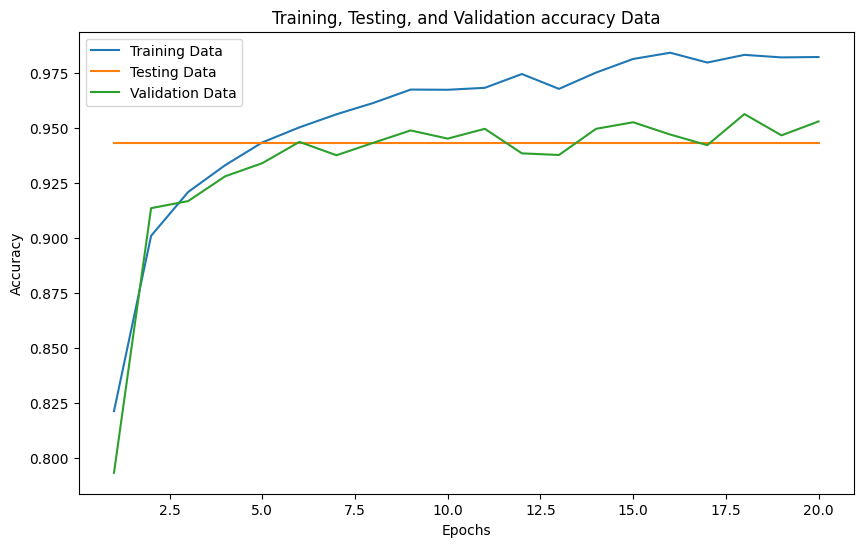

In [110]:
epochs = range(1,epoch_no+1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, training_acc_data, label='Training Data')
plt.plot(epochs, testing_acc_data, label='Testing Data')
plt.plot(epochs, val_acc_data, label='Validation Data')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training, Testing, and Validation accuracy Data')
plt.legend()
plt.show()

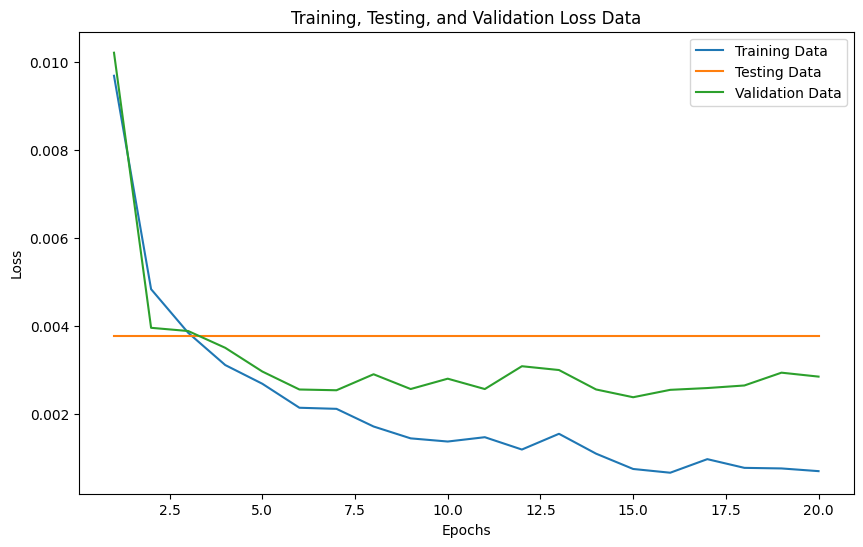

In [112]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss_data, label='Training Data')
plt.plot(epochs, testing_loss_data, label='Testing Data')
plt.plot(epochs, val_loss_data, label='Validation Data')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Testing, and Validation Loss Data')
plt.legend()
plt.show()

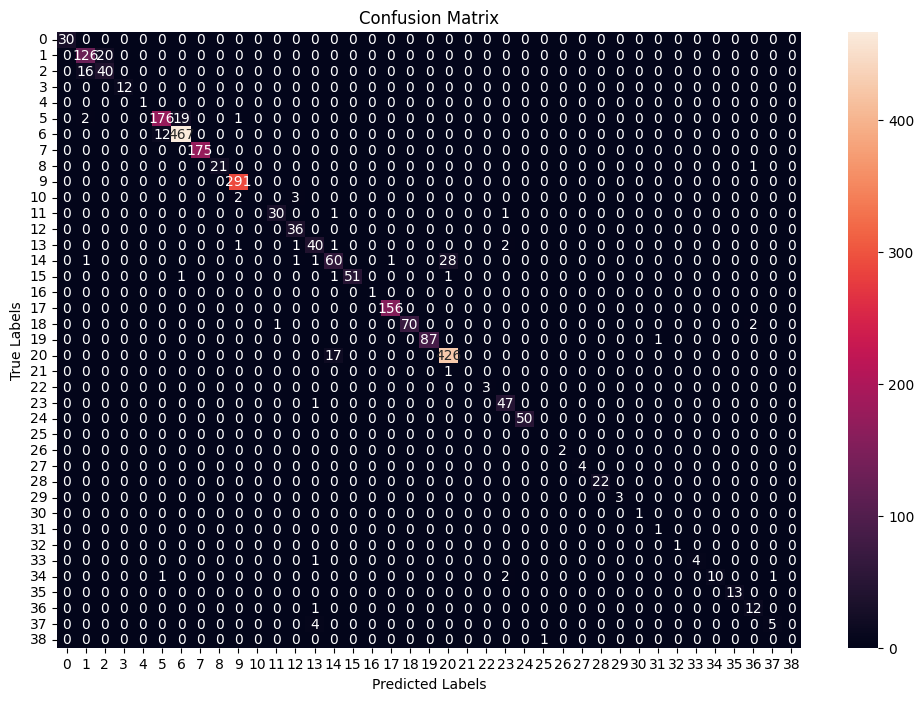

In [113]:
#Visualize the results
import seaborn as sns

from sklearn.metrics import confusion_matrix

cmat = confusion_matrix(Y_test.cpu(), Y_pred.cpu())
plt.figure(figsize=(12, 8))
sns.heatmap(cmat, annot=True, fmt="d")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


print()
print()


In [114]:
#Saving the weights of the trained neural network

torch.save(densenet_model.state_dict(), '/content/snehatal_dramados_kishoren_final_project.h5')

##Referenes

Assignment 0 and 1 of CSE 676 Deep Learning by Sneha Talapala

Assignment 2 of CSE 574 Intro to Machine Learning by Sneha Talapala